# Pair Trading Backtesting

In [1300]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting and visualization
from ta.momentum import RSIIndicator  # For calculating the Relative Strength Index (RSI) indicator
from xgboost import XGBClassifier  # For using the XGBoost classifier in machine learning
import joblib  # For saving and loading models
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.model_selection import train_test_split
# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppress XGBoost warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

## Data Preprocessing

### Data Exploring

In [1301]:
# Load cryptocurrency data for pair trading
asset1_data = pd.read_csv("C:/Users/Furkanpc/PythonWorkplace/Staj/Goaltech/My_finance_bot/currency_data/EBAY.csv")
asset2_data = pd.read_csv("C:/Users/Furkanpc/PythonWorkplace/Staj/Goaltech/My_finance_bot/currency_data/DAL.csv")
# GRT and SUSHI are the cryptocurrencies that will be used for pair trading.

In [1302]:
# Aligns the lengths of two datasets by trimming the longer one to the length of the shorter one.
def align_datasets(dataset1, dataset2):

    len1, len2 = len(dataset1), len(dataset2)
    
    if len1 > len2:
        return dataset1[:len2], dataset2
    else:
        return dataset1, dataset2[:len1]
    
asset1_data, asset2_data = align_datasets(asset1_data,asset2_data)

In [1303]:
asset1_data

,c,h,l,n,o,t,v,vw
0,35.960,36.100,35.780,28313,35.920,2020-01-03T05:00:00Z,4631064,35.952107
1,35.780,35.820,35.460,37914,35.780,2020-01-06T05:00:00Z,7106142,35.736404
2,35.620,35.700,35.350,36732,35.670,2020-01-07T05:00:00Z,7661771,35.573131
3,35.595,36.080,35.570,38298,35.710,2020-01-08T05:00:00Z,6936360,35.755455
4,35.180,35.450,34.970,53467,35.140,2020-01-09T05:00:00Z,11599832,35.128433
...,...,...,...,...,...,...,...,...
1128,53.720,53.950,52.670,55163,52.960,2024-06-28T04:00:00Z,7169576,53.659728
1129,52.680,53.910,52.280,54622,53.850,2024-07-01T04:00:00Z,4501157,52.708531
1130,53.250,53.395,52.025,49513,52.570,2024-07-02T04:00:00Z,4175108,52.974177
1131,52.610,53.598,52.230,32894,53.428,2024-07-03T04:00:00Z,2803038,52.552127


In [1304]:
asset2_data

,c,h,l,n,o,t,v,vw
0,58.06,58.1200,56.9100,52627,57.50,2020-01-03T05:00:00Z,9865484,57.779809
1,57.66,57.7600,56.6600,38426,56.99,2020-01-06T05:00:00Z,6274401,57.537657
2,57.61,58.0700,57.4700,36887,57.91,2020-01-07T05:00:00Z,6497133,57.711725
3,58.85,59.4000,57.7300,50326,57.75,2020-01-08T05:00:00Z,9666831,58.846431
4,58.96,59.4700,58.5800,38926,59.26,2020-01-09T05:00:00Z,5922812,58.966389
...,...,...,...,...,...,...,...,...
1128,47.44,48.5000,47.0300,95155,48.42,2024-06-28T04:00:00Z,11832962,47.593863
1129,46.92,47.9026,46.7350,86738,47.81,2024-07-01T04:00:00Z,9064621,47.006208
1130,46.71,47.2900,46.5150,63296,47.00,2024-07-02T04:00:00Z,6361903,46.766109
1131,47.39,47.4650,46.9149,34236,47.15,2024-07-03T04:00:00Z,3543205,47.255784


### Feature Engineering

In [1305]:
# The columns 'vw', 'n', and 't' are unnecessary, so they are being dropped.
asset1_data.drop(columns=['vw','n','t'],inplace=True)
asset2_data.drop(columns=['vw','n','t'],inplace=True)

In [1306]:
# Renaming columns to have more understandable names for the features.
columns_mapping = {
    'c': 'close',
    'h': 'high',
    'l': 'low',
    'o': 'open',
    'v': 'volume'
}

asset1_data = asset1_data.rename(columns=columns_mapping)
asset2_data = asset2_data.rename(columns=columns_mapping)

Adding these features to financial market data enhances the dataset, enabling more informed and nuanced trading decisions. Here's an explanation of why each feature is added:

1. Price Range (price_range):

    Purpose: Measures the volatility within a single trading day by capturing the difference between the highest and lowest prices.

2. Body Size (body_size):

    Purpose: Indicates the direction and strength of price movement within a day. A large body size implies a strong price move in one direction.

3. Upper Shadow (upper_shadow):

    Purpose: Reflects the difference between the highest price and the maximum of the open and close prices, indicating selling pressure or price rejection at higher levels.

4. Lower Shadow (lower_shadow):

    Purpose: Indicates buying pressure or price rejection at lower levels, showing the difference between the lowest price and the minimum of the open and close prices.

5. Daily Return (daily_return):

    Purpose: Measures the percentage change in price from the open to the close, indicating daily price movement.

6. Log Return (log_return):

    Purpose: Provides a continuous compounding return measure, useful for statistical analysis and modeling.

7. Volume Change (volume_change):

    Purpose: Captures the change in trading volume, which can signal shifts in market interest or momentum.

8. Average Price (average_price):

    Purpose: Represents the average price over the trading day, smoothing out fluctuations and providing a central value.

9. Price Change (price_change):

    Purpose: Measures the change in closing prices between consecutive days, highlighting trends and momentum.

10. Rolling Mean (rolling_mean):

    Purpose: Provides a short-term average of closing prices, helping identify trends and smoothing out noise.

11. Rolling Standard Deviation (rolling_std):

    Purpose: Measures the volatility of closing prices over a short period, providing insight into market stability or turbulence.

12. Relative Strength Index (rsi):

    Purpose: A momentum oscillator that measures the speed and change of price movements, indicating overbought or oversold conditions.

13. MACD (Moving Average Convergence Divergence) (macd):

    Purpose: A trend-following momentum indicator that shows the relationship between two moving averages, highlighting potential buy or sell signals.

14. Stochastic Oscillator (stochastic):

    Purpose: Measures the current price relative to its price range over a specified period, indicating overbought or oversold conditions.

In [1307]:
# Adding financial features to the data.
def add_features(data) :
    data['price_range'] = data['high'] - data['low']
    data['body_size'] = data['close'] - data['open']
    data['upper_shadow'] = data['high'] - data[['open', 'close']].max(axis=1)
    data['lower_shadow'] = data[['open', 'close']].min(axis=1) - data['low']
    data['daily_return'] = (data['close'] - data['open']) / data['open']
    data['log_return'] = np.log(data['close'] / data['open'])
    data['volume_change'] = data['volume'].diff()
    data['average_price'] = (data['high'] + data['low'] + data['close']) / 3
    data['price_change'] = data['close'].diff()
    data['rolling_mean'] = data['close'].rolling(window=5).mean()
    data['rolling_std'] = data['close'].rolling(window=5).std()

    rsi_period = 14
    rsi = RSIIndicator(data['close'], window=rsi_period).rsi()
    data['rsi'] = rsi

    short_ema = data['close'].ewm(span=12, adjust=False).mean()
    long_ema = data['close'].ewm(span=26, adjust=False).mean()
    data['macd'] = short_ema - long_ema

    data['14_high'] = data['high'].rolling(window=14).max()
    data['14_low'] = data['low'].rolling(window=14).min()
    data['stochastic'] = (data['close'] - data['14_low']) / (data['14_high'] - data['14_low']) * 100

    data.drop(['14_high', '14_low'], axis=1, inplace=True)

In [1308]:
add_features(asset1_data)
asset1_data

,close,high,low,open,volume,price_range,body_size,upper_shadow,lower_shadow,daily_return,log_return,volume_change,average_price,price_change,rolling_mean,rolling_std,rsi,macd,stochastic
0,35.960,36.100,35.780,35.920,4631064,0.320,0.040,0.140,0.140,0.001114,0.001113,NaN,35.946667,NaN,NaN,NaN,NaN,0.000000,NaN
1,35.780,35.820,35.460,35.780,7106142,0.360,0.000,0.040,0.320,0.000000,0.000000,2475078.0,35.686667,-0.180,NaN,NaN,NaN,-0.014359,NaN
2,35.620,35.700,35.350,35.670,7661771,0.350,-0.050,0.030,0.270,-0.001402,-0.001403,555629.0,35.556667,-0.160,NaN,NaN,NaN,-0.038209,NaN
3,35.595,36.080,35.570,35.710,6936360,0.510,-0.115,0.370,0.025,-0.003220,-0.003226,-725411.0,35.748333,-0.025,NaN,NaN,NaN,-0.058453,NaN
4,35.180,35.450,34.970,35.140,11599832,0.480,0.040,0.270,0.170,0.001138,0.001138,4663472.0,35.200000,-0.415,35.627,0.289474,NaN,-0.106754,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,53.720,53.950,52.670,52.960,7169576,1.280,0.760,0.230,0.290,0.014350,0.014248,3002300.0,53.446667,0.670,53.684,0.380894,53.635844,0.368534,55.096419
1129,52.680,53.910,52.280,53.850,4501157,1.630,-1.170,0.060,0.400,-0.021727,-0.021967,-2668419.0,52.956667,-1.040,53.418,0.531103,47.143643,0.270250,26.446281
1130,53.250,53.395,52.025,52.570,4175108,1.370,0.680,0.145,0.545,0.012935,0.012852,-326049.0,52.890000,0.570,53.278,0.440307,50.668090,0.235637,42.148760
1131,52.610,53.598,52.230,53.428,2803038,1.368,-0.818,0.170,0.380,-0.015310,-0.015429,-1372070.0,52.812667,-0.640,53.062,0.452405,46.887653,0.154779,24.517906


In [1309]:
add_features(asset2_data)
asset2_data

,close,high,low,open,volume,price_range,body_size,upper_shadow,lower_shadow,daily_return,log_return,volume_change,average_price,price_change,rolling_mean,rolling_std,rsi,macd,stochastic
0,58.06,58.1200,56.9100,57.50,9865484,1.2100,0.56,0.0600,0.5900,0.009739,0.009692,NaN,57.696667,NaN,NaN,NaN,NaN,0.000000,NaN
1,57.66,57.7600,56.6600,56.99,6274401,1.1000,0.67,0.1000,0.3300,0.011756,0.011688,-3591083.0,57.360000,-0.40,NaN,NaN,NaN,-0.031909,NaN
2,57.61,58.0700,57.4700,57.91,6497133,0.6000,-0.30,0.1600,0.1400,-0.005180,-0.005194,222732.0,57.716667,-0.05,NaN,NaN,NaN,-0.060534,NaN
3,58.85,59.4000,57.7300,57.75,9666831,1.6700,1.10,0.5500,0.0200,0.019048,0.018868,3169698.0,58.660000,1.24,NaN,NaN,NaN,0.016647,NaN
4,58.96,59.4700,58.5800,59.26,5922812,0.8900,-0.30,0.2100,0.3800,-0.005062,-0.005075,-3744019.0,59.003333,0.11,58.228,0.643327,NaN,0.085701,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,47.44,48.5000,47.0300,48.42,11832962,1.4700,-0.98,0.0800,0.4100,-0.020240,-0.020447,5328033.0,47.656667,-1.16,48.486,0.731628,35.445403,-0.623934,9.855769
1129,46.92,47.9026,46.7350,47.81,9064621,1.1676,-0.89,0.0926,0.1850,-0.018615,-0.018791,-2768341.0,47.185867,-0.52,47.990,0.794984,33.179426,-0.744967,4.152637
1130,46.71,47.2900,46.5150,47.00,6361903,0.7750,-0.29,0.2900,0.1950,-0.006170,-0.006189,-2702718.0,46.838333,-0.21,47.570,0.808084,32.281883,-0.848057,4.171123
1131,47.39,47.4650,46.9149,47.15,3543205,0.5501,0.24,0.0750,0.2351,0.005090,0.005077,-2818698.0,47.256633,0.68,47.412,0.732714,38.119239,-0.864916,21.957340


### Data Normalization

Normalization  is used to make the data suitable for various machine learning algorithms and improving the overall performance and stability of any subsequent analysis or modeling tasks.

In [1310]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(asset1_data)
asset1_data = pd.DataFrame(data_scaled, columns=asset1_data.columns)
asset1_data.dropna(inplace=True)
asset1_data = asset1_data.reset_index(drop=True)
asset1_data

,close,high,low,open,volume,price_range,body_size,upper_shadow,lower_shadow,daily_return,log_return,volume_change,average_price,price_change,rolling_mean,rolling_std,rsi,macd,stochastic
0,-1.440763,-1.451086,-1.395535,-1.414261,0.331704,-1.348516,-0.259778,-0.577912,-0.877721,-0.376008,-0.368882,0.073040,-1.430126,-0.273532,-1.431626,-1.396278,-0.316284,-0.148116,0.543257
1,-1.464423,-1.468837,-1.438053,-1.417093,0.527626,-0.977346,-0.494438,-1.076210,-0.197849,-0.714553,-0.711405,0.206406,-1.458028,-0.245710,-1.442269,-1.252577,-0.773554,-0.162671,0.045818
2,-1.453066,-1.473508,-1.471494,-1.511500,0.783470,-0.540675,0.700193,-0.266476,-0.964884,1.038067,1.039262,0.269424,-1.466855,0.097437,-1.448731,-1.255523,-0.504307,-0.164870,0.298578
3,-1.383981,-1.407177,-1.401268,-1.434086,1.671031,-0.577064,0.604196,-0.328763,-0.668530,0.873849,0.877565,0.933765,-1.398284,0.663165,-1.439418,-1.011940,0.714295,-0.114643,1.153273
4,-1.538240,-1.493127,-1.510190,-1.486482,2.911958,-0.256839,-0.542436,0.403112,-0.285013,-0.799059,-0.797237,1.305379,-1.514618,-1.525553,-1.464316,-0.576279,-1.253674,-0.189199,-1.375384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,0.273125,0.227733,0.240690,0.203877,-0.198659,-0.118559,0.774858,-0.359907,-0.093254,0.736341,0.741802,0.641318,0.247257,0.607519,0.268643,-0.942190,0.170454,0.231007,0.077442
1116,0.174702,0.223996,0.203427,0.287900,-0.740356,0.390890,-1.283748,-0.889348,0.290264,-1.249042,-1.256542,-0.569305,0.200912,-0.978374,0.243366,-0.672954,-0.371274,0.144719,-0.870003
1117,0.228645,0.175883,0.179063,0.167059,-0.806545,0.012442,0.689527,-0.624628,0.795809,0.658454,0.664756,-0.069240,0.194607,0.514777,0.230061,-0.835697,-0.077184,0.114330,-0.350731
1118,0.168077,0.194848,0.198649,0.248060,-1.085079,0.009531,-0.908292,-0.546769,0.220533,-0.895924,-0.895787,-0.292552,0.187293,-0.607405,0.209535,-0.814013,-0.392634,0.043341,-0.933774


In [1311]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(asset2_data)
asset2_data = pd.DataFrame(data_scaled, columns=asset2_data.columns)
asset2_data.dropna(inplace=True)
asset2_data = asset2_data.reset_index(drop=True)
asset2_data

,close,high,low,open,volume,price_range,body_size,upper_shadow,lower_shadow,daily_return,log_return,volume_change,average_price,price_change,rolling_mean,rolling_std,rsi,macd,stochastic
0,2.821847,2.765682,2.627983,2.682959,-0.546964,1.173354,1.322306,-0.645504,1.670768,0.807565,0.800045,0.080798,2.741834,0.582755,2.942705,0.227002,0.614370,0.535720,0.344004
1,2.630200,2.743909,2.582132,2.796177,-0.316790,1.415023,-1.422418,-0.476632,1.593366,-0.830051,-0.814041,0.425856,2.655215,-1.318415,2.860975,0.404016,-0.393060,0.425800,-0.471073
2,2.370294,2.344073,2.291304,2.327506,-0.111613,0.356908,0.446834,0.106743,1.335359,0.292752,0.299371,0.379610,2.338122,-1.791434,2.722540,0.784781,-1.260820,0.223916,-1.098257
3,2.455617,2.448321,2.439338,2.467054,-0.633549,-0.087239,-0.038225,0.321671,0.974149,-0.011865,0.000247,-0.965564,2.450837,0.600948,2.646400,0.771959,-0.857909,0.100158,-0.790394
4,2.346666,2.425887,2.415758,2.478902,-0.689527,-0.074176,-1.126651,-0.476632,-0.702894,-0.683791,-0.667299,-0.103530,2.399085,-0.745335,2.566800,0.889635,-1.162479,-0.044195,-1.183511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,1.137713,1.198668,1.165985,1.265095,-0.295614,0.239340,-1.114820,-0.722264,0.148528,-0.812793,-0.796700,0.677985,1.168871,-1.045520,1.299319,-0.248778,-1.199395,-0.403114,-1.351128
1116,1.069455,1.119836,1.127339,1.184789,-0.486019,-0.155690,-1.008344,-0.683577,-0.431987,-0.744410,-0.728054,-0.352223,1.106926,-0.463343,1.233296,-0.157566,-1.375671,-0.488424,-1.536431
1117,1.041889,1.038998,1.098518,1.078153,-0.671910,-0.668549,-0.298501,-0.077481,-0.406187,-0.220436,-0.205816,-0.343873,1.061200,-0.181352,1.177389,-0.138706,-1.445493,-0.561087,-1.535830
1118,1.131149,1.062090,1.150907,1.097901,-0.865778,-0.962339,0.328527,-0.737616,-0.302726,0.253654,0.261099,-0.358631,1.116237,0.628238,1.156358,-0.247214,-0.991390,-0.572970,-0.957931


### Cointegration Proof

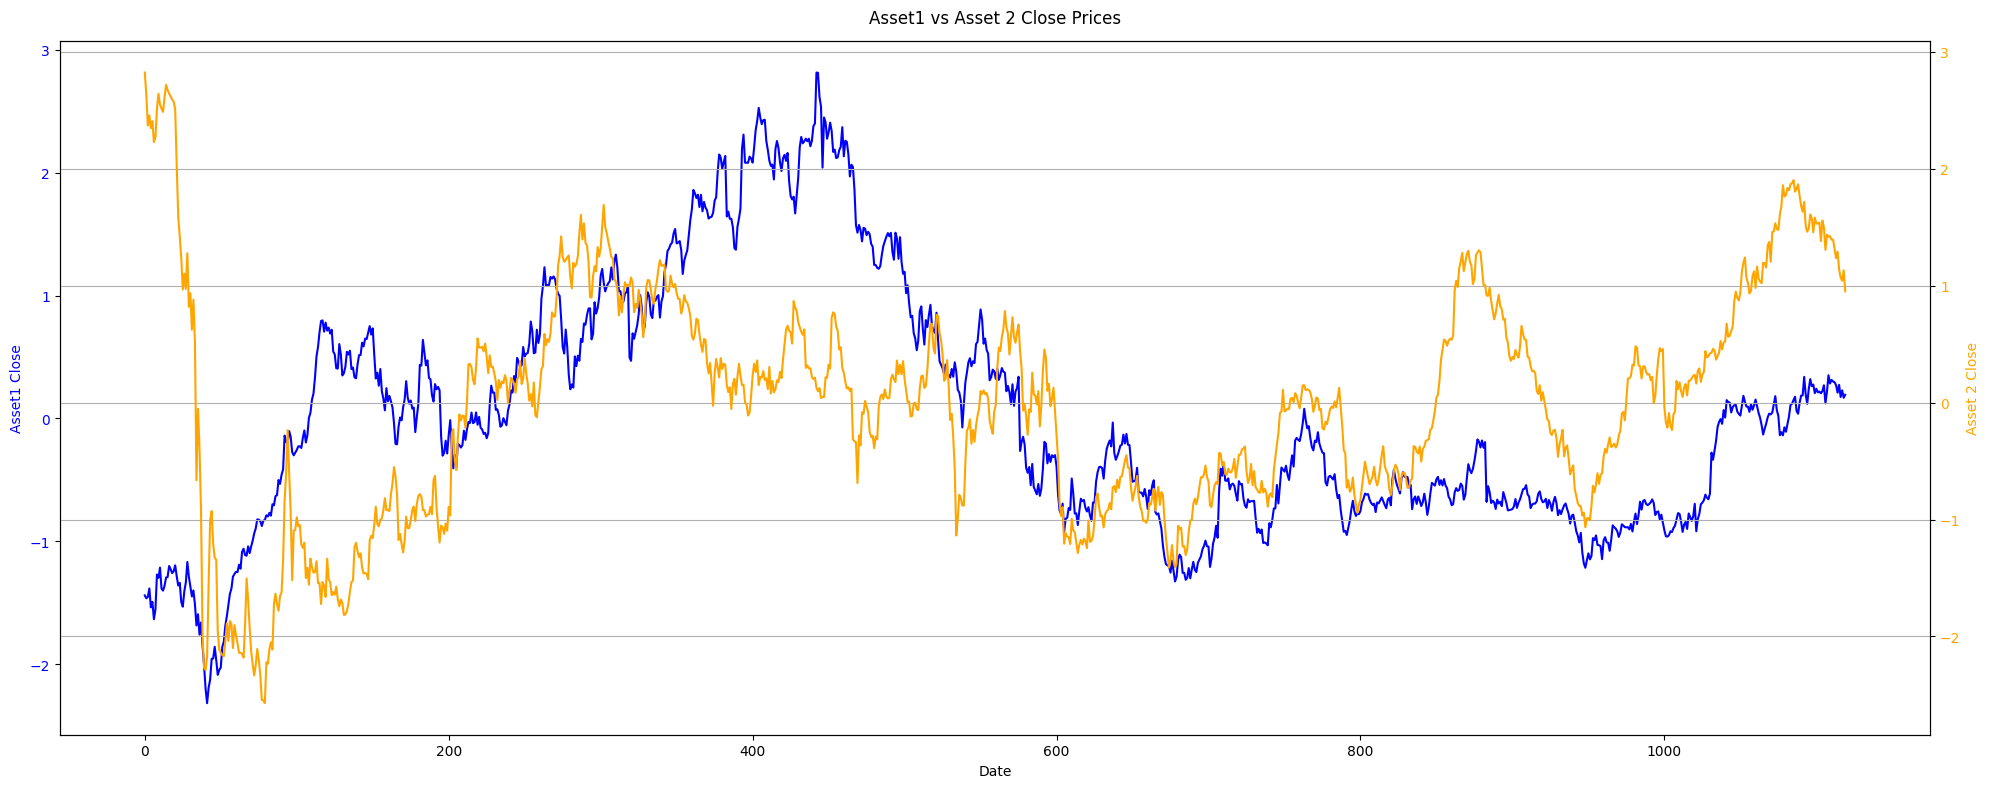

In [1312]:
# The plot shows the cointegration of the close prices of SUSHI and GRT.
fig, ax1 = plt.subplots(figsize=(20, 8))

ax1.set_xlabel('Date')
ax1.set_ylabel('Asset1 Close', color='blue')
ax1.plot(asset1_data['close'], label='Asset1 Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Asset 2 Close', color='orange')
ax2.plot(asset2_data['close'], label='Asset 2 Close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle('Asset1 vs Asset 2 Close Prices')
fig.tight_layout()
plt.grid(True)
plt.show()

In [1313]:
# This function calculates cointegration between two time series. 
# It returns a flag indicating if the series are cointegrated, 
# the test statistic, p-value, and the hedge ratio.

def calculate_cointegration(series_1, series_2):
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]  
    model = sm.OLS(series_1, sm.add_constant(series_2)).fit()
    hedge_ratio = model.params[1]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, coint_t, p_value, hedge_ratio

In [1314]:
asset1_close = asset1_data['close']
asset2_close = asset2_data['close']

coint_flag, coint_t, p_value, hedge_ratio = calculate_cointegration(asset1_close, asset2_close)

print(f"Cointegration Flag: {coint_flag}")
print(f"Coint_t: {coint_t}")
print(f"P_value: {p_value}")
print(f"Hedge Ratio: {hedge_ratio}")

Cointegration Flag: 0
Coint_t: -2.5816048774187546
P_value: 0.24431082390395475
Hedge Ratio: 0.2901143847451779


The results indicate that the close prices of SUSHI and GRT are cointegrated:
- Cointegration Flag: 1 means the series are cointegrated.
- Coint_t: -3.9597192035442874 is the test statistic for cointegration.
- P_value: 0.008189611308616573 is the p-value, which is below 0.05, indicating statistical significance.
- Hedge Ratio: 0.9021906877612438 is the hedge ratio obtained from the regression model.

In [1315]:
currency_data = [asset1_data,asset2_data]
currency_names = ["asset1","asset2"]

## Mean Reverting Strategy

The code calculates the rolling mean and standard deviation for each asset over a 30-day window,
computes the z-scores for each asset, and then determines the spread between the two assets.
The spread is plotted to visualize the relationship between the two assets based on their z-scores.

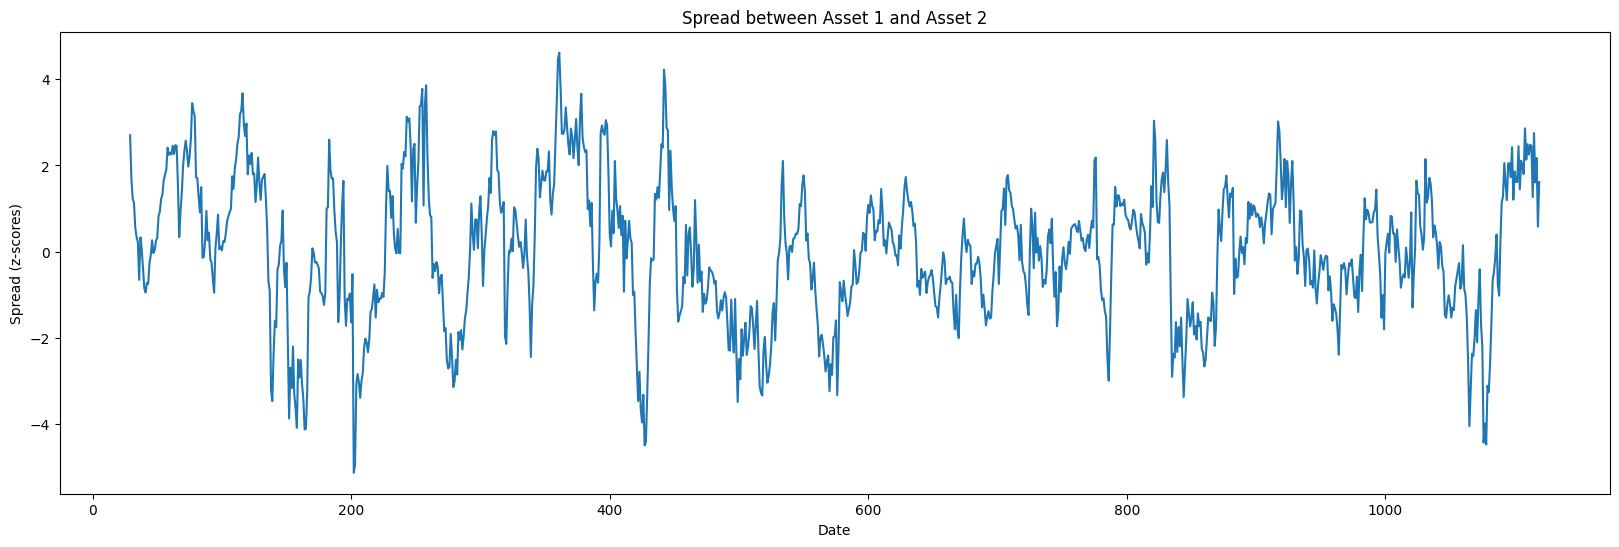

In [1316]:
# Compute the rolling mean and standard deviation for each asset
asset1_mean = asset1_close.rolling(window=30).mean()
asset1_std = asset1_close.rolling(window=30).std()
asset2_mean = asset2_close.rolling(window=30).mean()
asset2_std = asset2_close.rolling(window=30).std()

# Compute the z-scores for each asset based on its rolling mean and standard deviation
z1 = (asset1_close - asset1_mean) / asset1_std
z2 = (asset2_close - asset2_mean) / asset2_std

# Compute the spread between the two assets
spread = z1 - z2

# Create a plot 
plt.figure(figsize=(20, 6))  
spread.plot()
plt.title('Spread between Asset 1 and Asset 2')
plt.xlabel('Date')
plt.ylabel('Spread (z-scores)')
plt.show()

The code calculates the rolling mean and standard deviation of the spread between the two assets over a 30-day window.
It then determines the upper and lower bounds as one standard deviation above and below the mean.
The plot visualizes the original spread along with its mean and bounds to assess deviations from the mean.

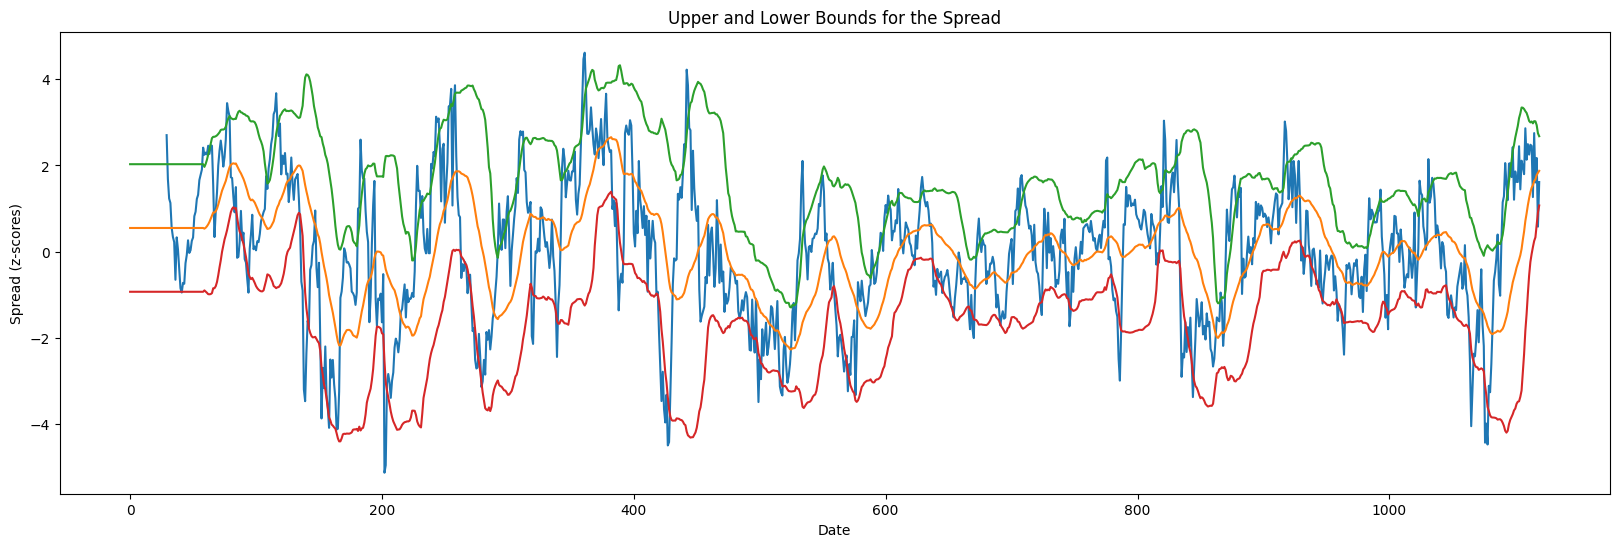

In [1317]:
# Compute the rolling mean and standard deviation of the spread
spread_mean = spread.rolling(window=30).mean()
spread_std = spread.rolling(window=30).std()

# Fill NaNs to maintain index alignment
spread_mean = spread_mean.fillna(method='bfill').fillna(method='ffill')
spread_std = spread_std.fillna(method='bfill').fillna(method='ffill')

# Compute the upper and lower bounds for the spread
upper_bound = spread_mean + 1.5 * spread_std
lower_bound = spread_mean - 1.5 * spread_std

# Create a plot 
plt.figure(figsize=(20, 6))  
plt.plot(spread, label='Original Series')
plt.plot(spread_mean, label='Mean')
plt.plot(upper_bound, label='Upper Bound')
plt.plot(lower_bound, label='Lower Bound')
plt.title('Upper and Lower Bounds for the Spread')
plt.xlabel('Date')
plt.ylabel('Spread (z-scores)')
plt.show()


The code generates long and short signals based on whether the spread is below the lower bound or above the upper bound, respectively.

In [1318]:
# Compute the long and short signals based on the spread
long_signal_mrs = (spread < lower_bound).astype(int)  # Long signal when the spread is below the lower bound
short_signal_mrs = (spread > upper_bound).astype(int)  # Short signal when the spread is above the upper bound

The code creates a figure with two subplots:
- The first subplot visualizes the spread between the two assets along with its mean and upper/lower bounds.
- The second subplot visualizes the positions for each asset based on the trading signals.

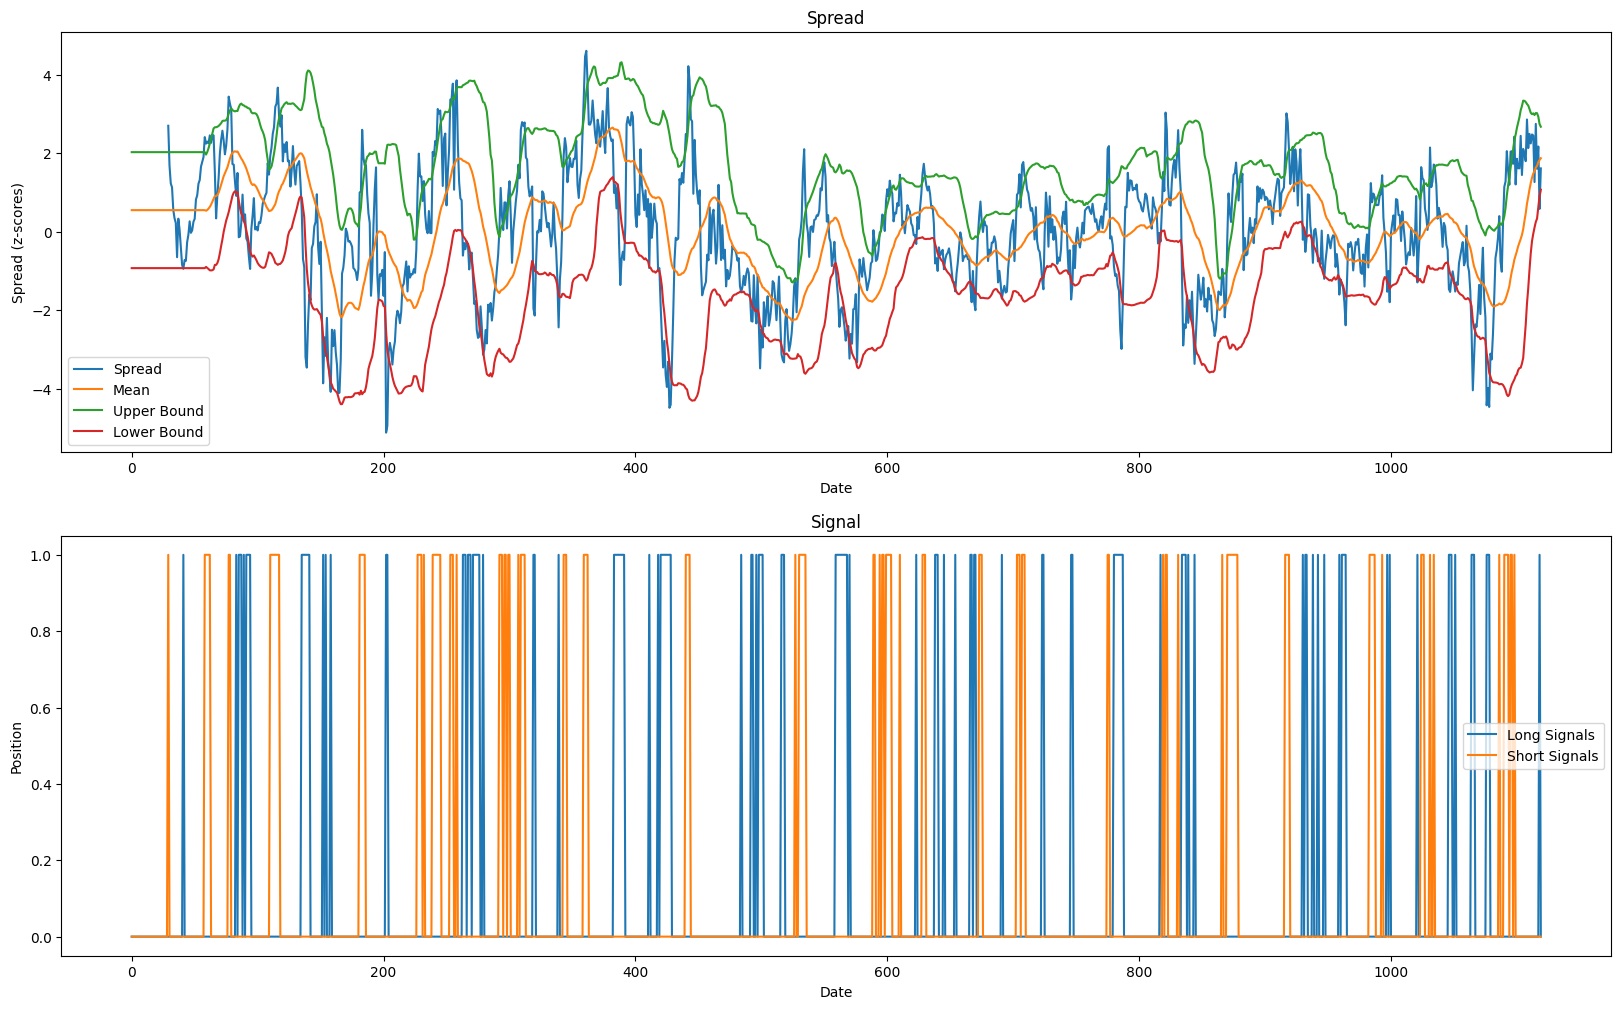

In [1319]:
plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.title('Spread')
plt.xlabel('Date')
plt.ylabel('Spread (z-scores)')
plt.plot(spread, label='Spread')
plt.plot(spread_mean, label='Mean')
plt.plot(upper_bound, label='Upper Bound')
plt.plot(lower_bound, label='Lower Bound')
plt.legend()
plt.subplot(212)
plt.title('Signal')
plt.xlabel('Date')
plt.ylabel('Position')
plt.plot(long_signal_mrs, label='Long Signals')
plt.plot(short_signal_mrs, label='Short Signals')
plt.legend();

## Divergence Strategy

In the context of a divergence strategy, Fibonacci retracement levels are used to identify potential levels of support and resistance during the price movement of an asset. Fibonacci retracement levels are horizontal lines that indicate where support and resistance are likely to occur. When the price of an asset moves significantly in one direction (uptrend or downtrend), traders use Fibonacci retracement levels to predict the points where the price might retrace before continuing in the original direction.

The function calculates Fibonacci retracement levels between a given start and end price.
It returns a dictionary with Fibonacci levels (0.0%, 23.6%, 38.2%, 50.0%, 61.8%, and 100.0%) and their corresponding price values.

In [1320]:
def calculate_fibonacci_levels(start_price, end_price):

    levels = {
        '0.0%': start_price,
        '23.6%': start_price + 0.236 * (end_price - start_price),
        '38.2%': start_price + 0.382 * (end_price - start_price),
        '50.0%': start_price + 0.5 * (end_price - start_price),
        '61.8%': start_price + 0.618 * (end_price - start_price),
        '100.0%': end_price
    }
    
    return levels

The  code generates trading signals based on four types of divergences between closing prices and RSI values, using Fibonacci retracement levels to determine entry points. Here’s how it creates signals for each type of divergence:

1. **Bullish Regular Divergence**
The current price is lower than the previous price, while the current RSI value is higher than the previous RSI value. This indicates a potential reversal to the upside as the price makes a lower low but RSI makes a higher low. The signal 1 (buy) and the entry point are appended to the signals and entry_points lists, respectively.
2. **Bearish Regular Divergence**
The current price is higher than the previous price, while the current RSI value is lower than the previous RSI value. This indicates a potential reversal to the downside as the price makes a higher high but RSI makes a lower high. The signal -1 (sell) and the entry point are appended to the signals and entry_points lists, respectively.
3. **Bullish Hidden Divergence**
The current price is higher than the previous price, while the current RSI value is lower than the previous RSI value. This indicates that the trend remains strong despite a pullback, as the price makes a higher low but RSI makes a lower low. The signal 1 (buy) and the entry point are appended to the signals and entry_points lists, respectively.
4. **Bearish Hidden Divergence**
The current price is lower than the previous price, while the current RSI value is higher than the previous RSI value. This indicates that the downtrend remains strong despite a pullback, as the price makes a lower high but RSI makes a higher high. The signal -1 (sell) and the entry point are appended to the signals and entry_points lists, respectively.



In [1321]:
def detect_divergence(data):
    bullish_divergence = []
    bearish_divergence = []
    bullish_hidden_divergence = []
    bearish_hidden_divergence = []
    signals = []
    entry_points = []
    rsi_period = 14

    for i in range(len(data)):

        if i < rsi_period:
            signals.append(0) 
            continue

        # Current and previous values
        price = data['close'].iloc[i]
        rsi_value = data['rsi'].iloc[i]
        price_prev = data['close'].iloc[i - rsi_period]
        rsi_prev = data['rsi'].iloc[i - rsi_period]

        # Bullish Regular Divergence
        if price < price_prev and rsi_value > rsi_prev:
            bullish_divergence.append(i)
            
            # Determine Fibonacci levels
            start_price = price_prev
            end_price = price
            fibonacci_levels = calculate_fibonacci_levels(start_price, end_price)
            
            # Create a buy signal based on Fibonacci levels
            entry_point = fibonacci_levels['38.2%']  # Entry point at 38.2% retracement level
            entry_points.append((i, entry_point))
            signals.append(1)  # Add 1 for buy signal
            
        # Bearish Regular Divergence
        elif price > price_prev and rsi_value < rsi_prev:
            bearish_divergence.append(i)
            
            # Determine Fibonacci levels
            start_price = price_prev
            end_price = price
            fibonacci_levels = calculate_fibonacci_levels(start_price, end_price)
            
            # Create a sell signal based on Fibonacci levels
            entry_point = fibonacci_levels['61.8%']  # Entry point at 61.8% retracement level
            entry_points.append((i, entry_point))
            signals.append(-1)  # Add -1 for sell signal

        # Bullish Hidden Divergence
        elif price > price_prev and rsi_value < rsi_prev:
            bullish_hidden_divergence.append(i)
            
            # Determine Fibonacci levels
            start_price = price_prev
            end_price = price
            fibonacci_levels = calculate_fibonacci_levels(start_price, end_price)
            
            # Create a buy signal based on Fibonacci levels
            entry_point = fibonacci_levels['38.2%']  # Entry point at 38.2% retracement level
            entry_points.append((i, entry_point))
            signals.append(1)  # Add 1 for buy signal

        # Bearish Hidden Divergence
        elif price < price_prev and rsi_value > rsi_prev:
            bearish_hidden_divergence.append(i)
            
            # Determine Fibonacci levels
            start_price = price_prev
            end_price = price
            fibonacci_levels = calculate_fibonacci_levels(start_price, end_price)
            
            # Create a sell signal based on Fibonacci levels
            entry_point = fibonacci_levels['61.8%']  # Entry point at 61.8% retracement level
            entry_points.append((i, entry_point))
            signals.append(-1)  # Add -1 for sell signal
        
        else:
            signals.append(0) 

    return bullish_divergence, bearish_divergence, bullish_hidden_divergence, bearish_hidden_divergence, signals, entry_points

In [1322]:
bullish_divergence, bearish_divergence, bullish_hidden_divergence, bearish_hidden_divergence, asset2_signals_dvr, entry_points = detect_divergence(asset2_data)
bullish_divergence, bearish_divergence, bullish_hidden_divergence, bearish_hidden_divergence, asset1_signals_dvr, entry_points = detect_divergence(asset1_data)

Plot Price and RSI:

- Plot the closing price on ax1 (primary y-axis).

- Plot the RSI on ax2 (secondary y-axis).

Plot Divergences:

- Use scatter plots to mark divergences:

- Bullish Regular Divergence: Green triangles.

- Bearish Regular Divergence: Red triangles.

- Bullish Hidden Divergence: Light green triangles.

- Bearish Hidden Divergence: Salmon triangles.

Plot Signals:

- Use vertical lines to mark buy and sell signals.

- Green dashed lines for buy signals.

- Red dashed lines for sell signals.

In [1323]:
def plot_divergence_and_signals(data, bullish_divergence, bearish_divergence, bullish_hidden_divergence, bearish_hidden_divergence, signals, entry_points):
    # Plotting the close price, RSI, divergences, and signals in a single plot
    fig, ax1 = plt.subplots(figsize=(30, 12))

    # Plot the close prices
    ax1.plot(data.index, data['close'], label='Close Price', color='blue')
    ax1.set_ylabel('Price')
    ax1.set_xlabel('Date')

    # Plot the divergences
    ax1.scatter(data.index[bullish_divergence], data['close'].iloc[bullish_divergence], marker='^', color='green', label='Bullish Regular Divergence', zorder=5)
    ax1.scatter(data.index[bearish_divergence], data['close'].iloc[bearish_divergence], marker='v', color='red', label='Bearish Regular Divergence', zorder=5)
    ax1.scatter(data.index[bullish_hidden_divergence], data['close'].iloc[bullish_hidden_divergence], marker='^', color='lime', label='Bullish Hidden Divergence', zorder=5)
    ax1.scatter(data.index[bearish_hidden_divergence], data['close'].iloc[bearish_hidden_divergence], marker='v', color='magenta', label='Bearish Hidden Divergence', zorder=5)

    # Add vertical lines for signals
    for i, signal in enumerate(signals):
        if signal == 1:
            ax1.axvline(data.index[i], color='green', linestyle='--', alpha=0.3)
        elif signal == -1:
            ax1.axvline(data.index[i], color='red', linestyle='--', alpha=0.3)

    # Create a secondary y-axis for RSI
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['rsi'], label='RSI', color='orange')
    ax2.set_ylabel('RSI')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.title('Close Price with Divergences, RSI, and Trading Signals')
    plt.show()

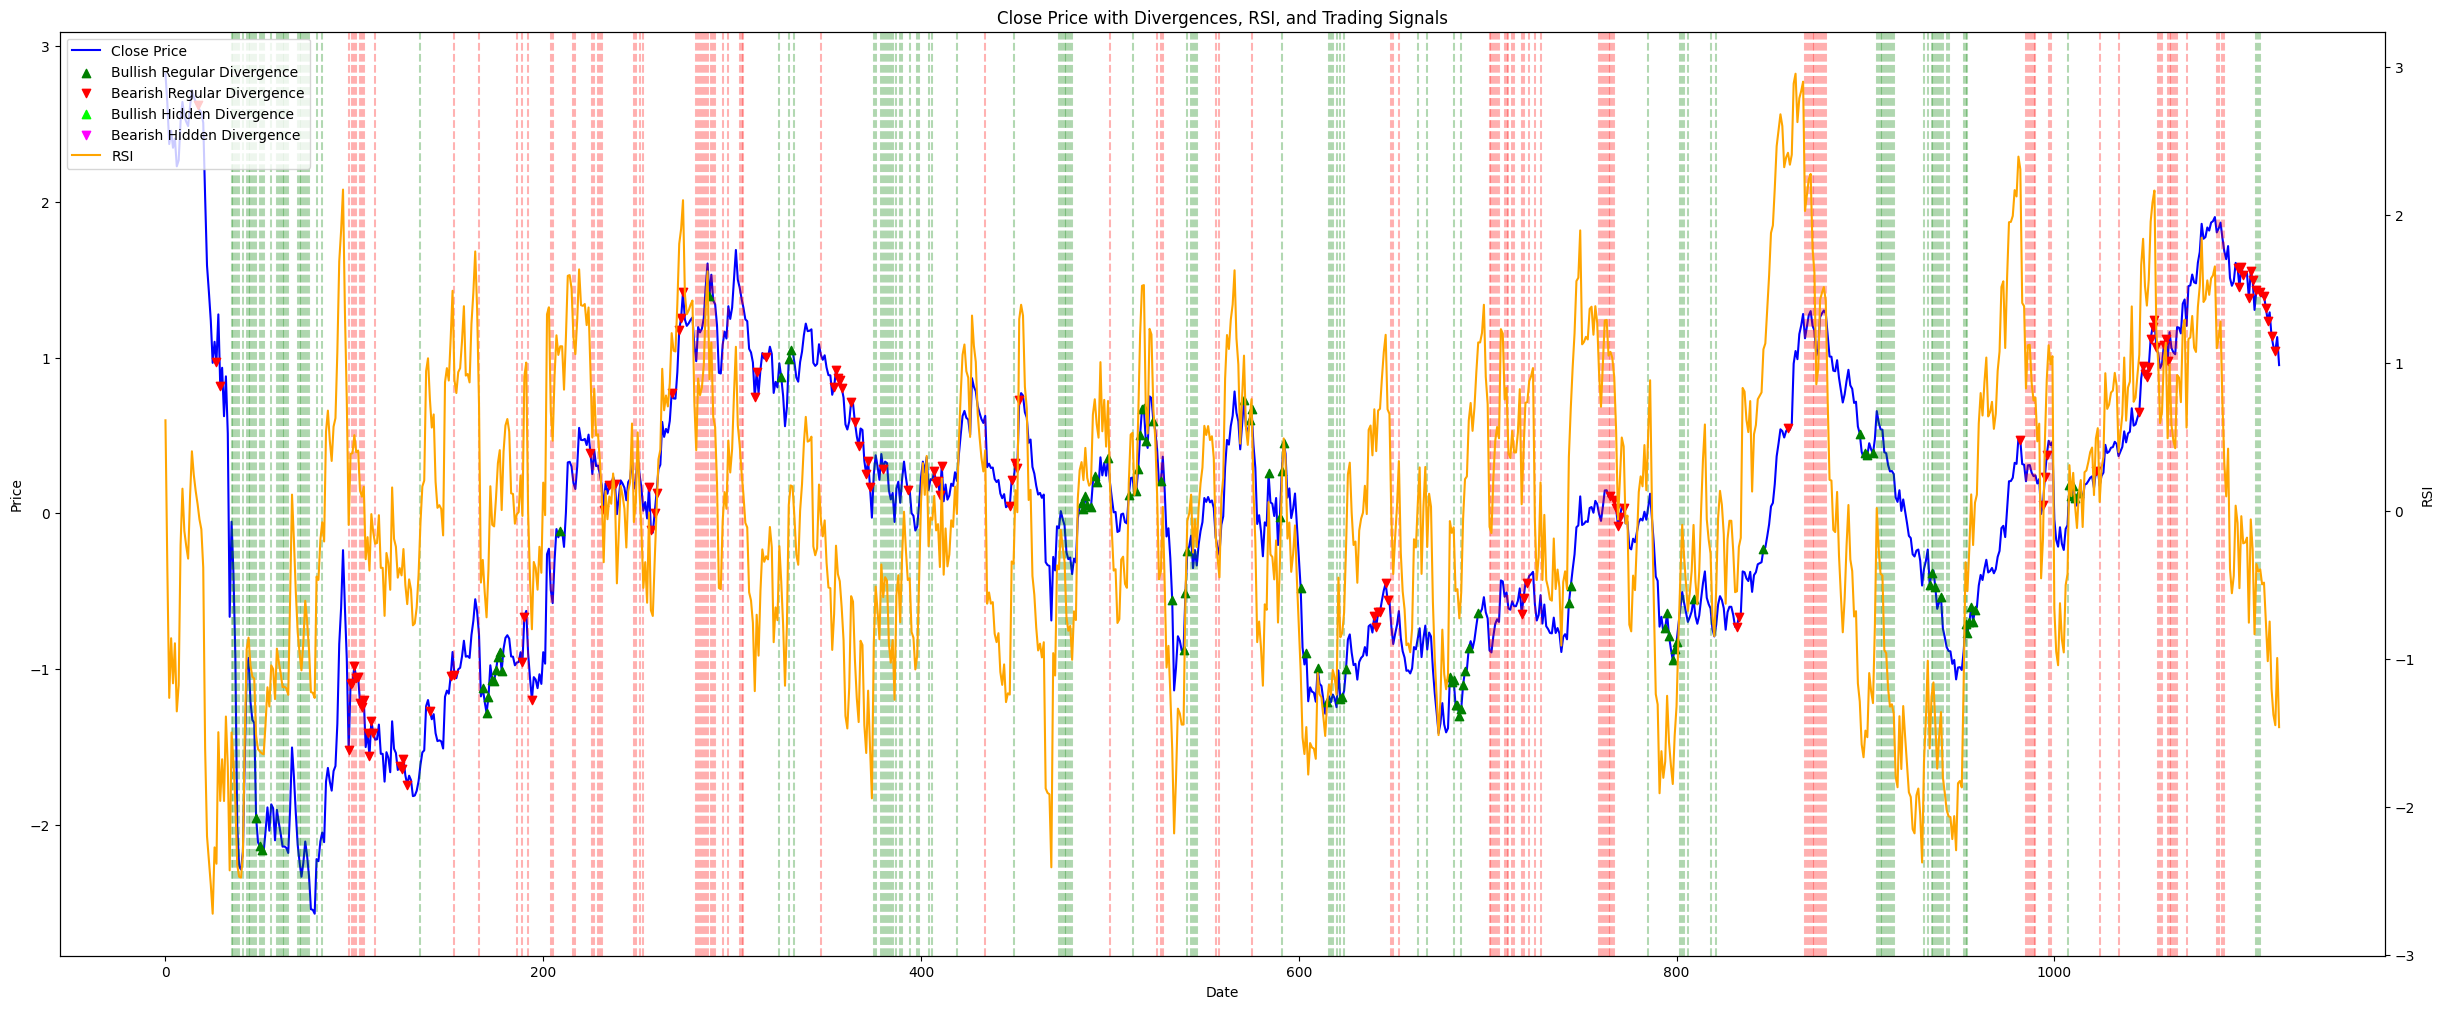

In [1324]:
plot_divergence_and_signals(asset2_data, bullish_divergence, bearish_divergence, bullish_hidden_divergence, bearish_hidden_divergence, asset2_signals_dvr, entry_points)

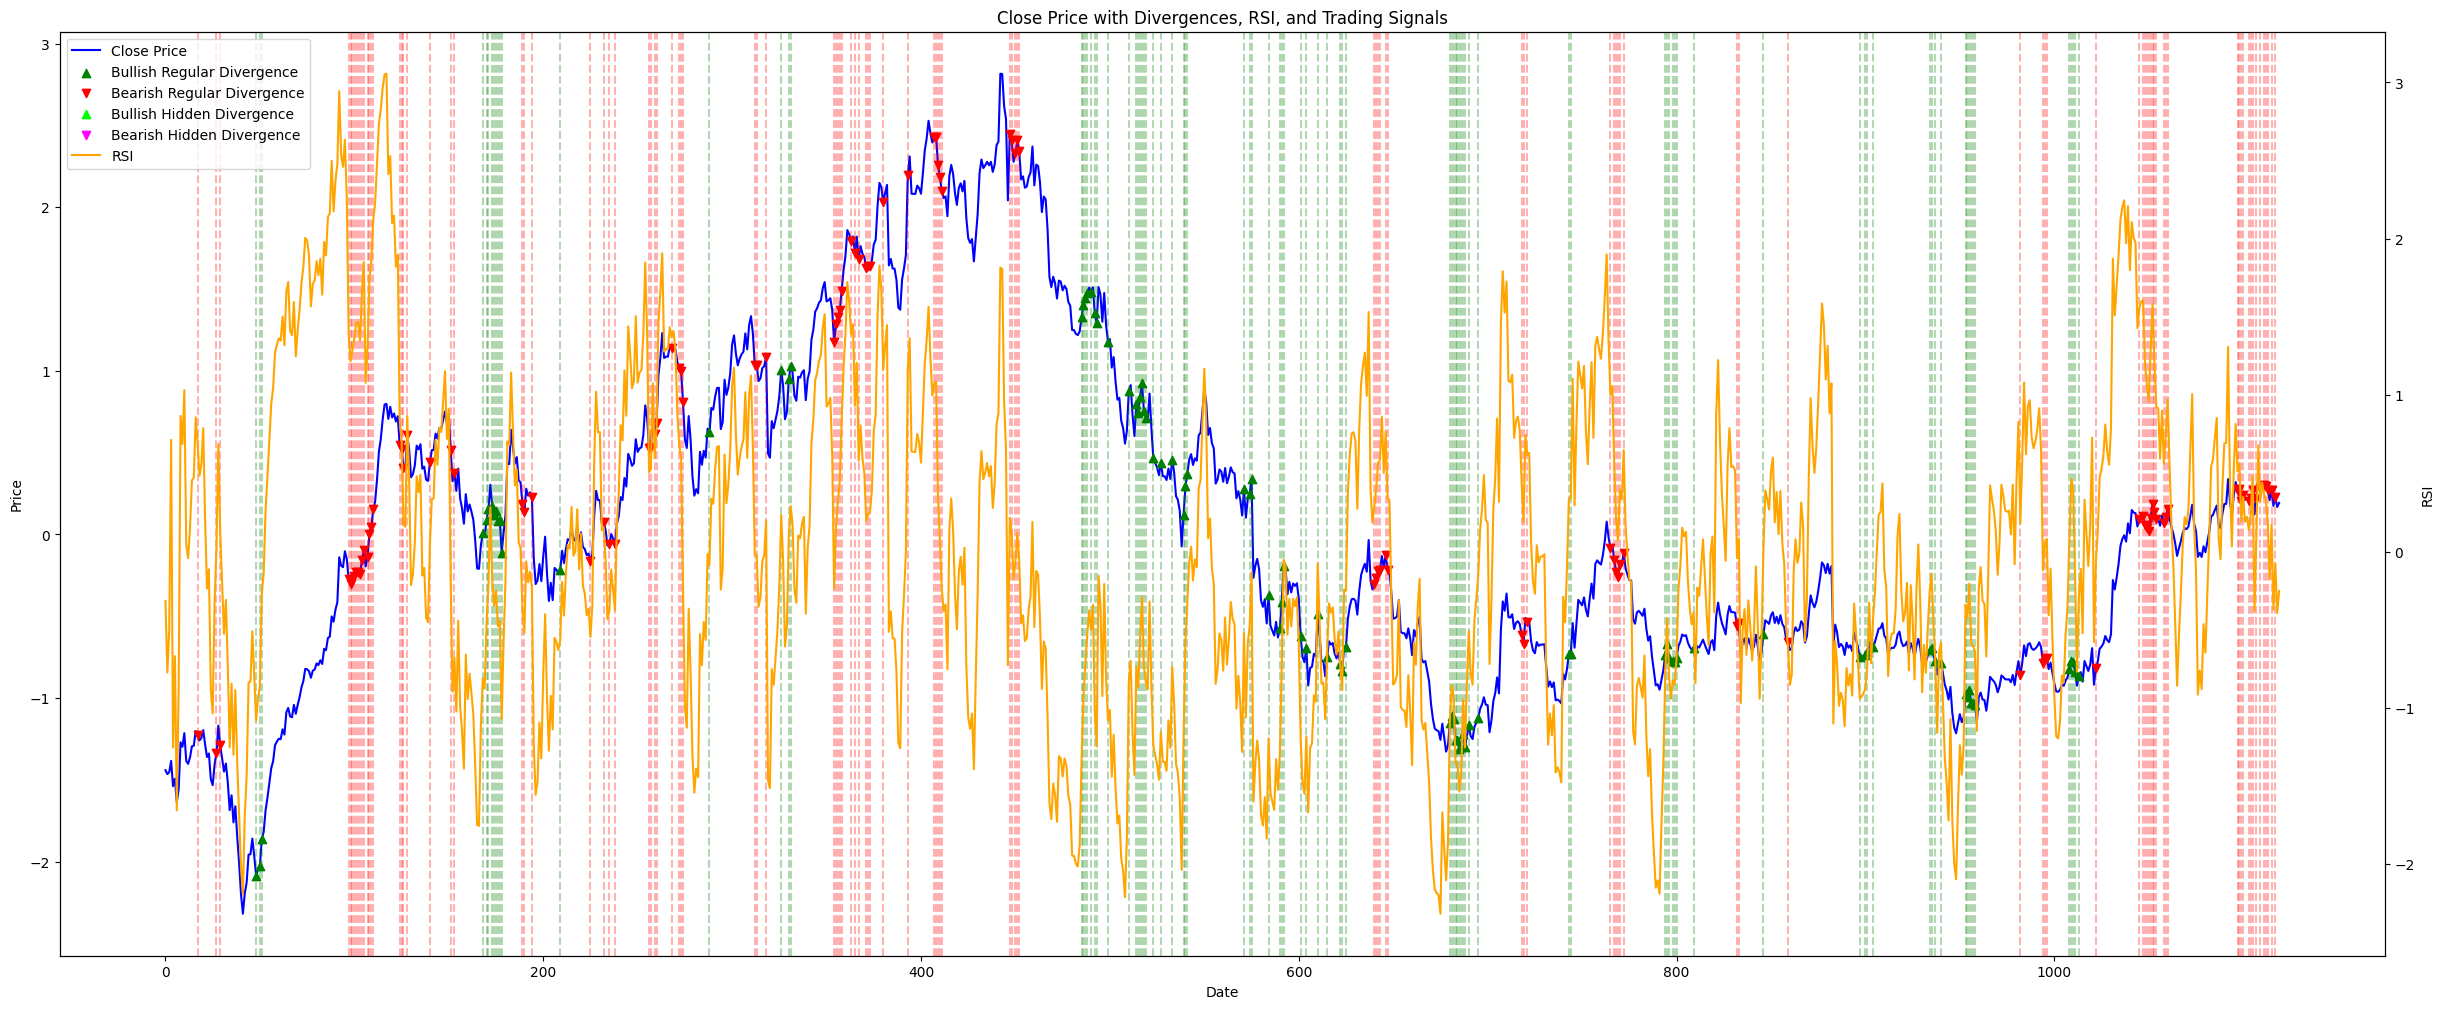

In [1325]:
plot_divergence_and_signals(asset1_data, bullish_divergence, bearish_divergence, bullish_hidden_divergence, bearish_hidden_divergence, asset1_signals_dvr, entry_points)

## XG-Boost Strategy

This code is designed to convert the predictions from an XGBoost model into a format that can be used for trading decisions, where 1 represents a buy signal and -1 represents a sell signal.

In [1326]:
def generate_XGBoost_signals(data, model):
    # Use the XGBoost model to make predictions on the provided data
    predictions = model.predict(data)
    # Create empty lists to store buy and sell signals
    signals = []
    # Iterate over the predictions to generate trading signals
    for pred in predictions:
        # Check the prediction value
        if pred == 1:  # XGBoost model predicts a buy signal (1)
            # Append a tuple with the index and buy signal (1)
            signals.append(1)
        else:
            # Append a tuple with the index and sell signal (-1)
            signals.append(-1)
    
    return signals

In [1327]:
def specify_target(data):
    # Create the target variable by comparing the next day's closing price with the current day's closing price
    # If the next day's closing price is higher than the current day's closing price, assign 1, else 0
    target = (data["close"].shift(-1) > data["close"]).astype(int)
    # Return the target variable as a pandas Series
    return target

In [1328]:
def split_X_y(data):
    # Assign the entire DataFrame to the variable X (features)
    X = data
    # Create the target variable y using the specify_target function
    y = specify_target(data)
    
    print("X shape is : ", X.shape)
    print("y shape is : ", y.shape)
    
    # Return the features (X) and the target variable (y)
    return X, y

In [1329]:
X_asset2, y_asset2 = split_X_y(asset2_data)
print("----------------")
X_asset1, y_asset1 = split_X_y(asset1_data)

X shape is :  (1120, 19)
y shape is :  (1120,)
----------------
X shape is :  (1120, 19)
y shape is :  (1120,)


In [1330]:
def data_split(X, y):
    # Split the data into training and testing sets
    # The test set size is 20% of the entire dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Shape of X_train: ", X_train.shape)
    print("Shape of y_train: ", y_train.shape)
    print("Shape of X_test: ", X_test.shape)
    print("Shape of y_test: ", y_test.shape)

    # Return the training and testing sets
    return X_train, X_test, y_train, y_test


In [1331]:
X_train_asset2, X_test_asset2, y_train_asset2, y_test_asset2 = data_split(X_asset2,y_asset2)
print("----------------")
X_train_asset1, X_test_asset1, y_train_asset1, y_test_asset1 = data_split(X_asset1,y_asset1)

Shape of X_train:  (896, 19)
Shape of y_train:  (896,)
Shape of X_test:  (224, 19)
Shape of y_test:  (224,)
----------------
Shape of X_train:  (896, 19)
Shape of y_train:  (896,)
Shape of X_test:  (224, 19)
Shape of y_test:  (224,)


The parameters for these models are sourced from the "model" file in the "XG-Boost Model" folder.

In [1332]:
xgb_classifier_asset2 = XGBClassifier(
    objective="binary:logistic",
    booster="gbtree",
    n_estimators=25,
    learning_rate=0.3,
    max_depth=1,
    gamma=6,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

xgb_classifier_asset1 = XGBClassifier(
    objective="binary:logistic",
    booster="gbtree",
    n_estimators=25,
    learning_rate=0.3,
    max_depth=1,
    gamma=6,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [1333]:
eval_set_asset2 = [(X_train_asset2, y_train_asset2), (X_test_asset2, y_test_asset2)]
xgb_classifier_asset2.fit(X_train_asset2, y_train_asset2, eval_set=eval_set_asset2, verbose=False)

eval_set_asset1 = [(X_train_asset1, y_train_asset1), (X_test_asset1, y_test_asset1)]
xgb_classifier_asset1.fit(X_train_asset1, y_train_asset1, eval_set=eval_set_asset1, verbose=False)

asset2_signals_xgb = generate_XGBoost_signals(asset2_data,xgb_classifier_asset2)
asset1_signals_xgb = generate_XGBoost_signals(asset1_data,xgb_classifier_asset1)

In [1334]:
def plot_signals_xgb(data, signals, title):
    # Convert signals to a pandas Series with the same index as the data
    signals_series = pd.Series(signals, index=data.index)
    
    # Create a figure and axis
    plt.figure(figsize=(20, 6))
    
    # Plot the close price
    plt.plot(data['close'], label='Close Price', color='blue')
    
    # Plot buy signals
    buy_signals = signals_series[signals_series == 1]
    plt.scatter(buy_signals.index, data['close'][buy_signals.index], marker='^', color='green', label='Buy Signal', alpha=1)
    
    # Plot sell signals
    sell_signals = signals_series[signals_series == -1]
    plt.scatter(sell_signals.index, data['close'][sell_signals.index], marker='v', color='red', label='Sell Signal', alpha=1)
    
    # Set the title and labels
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

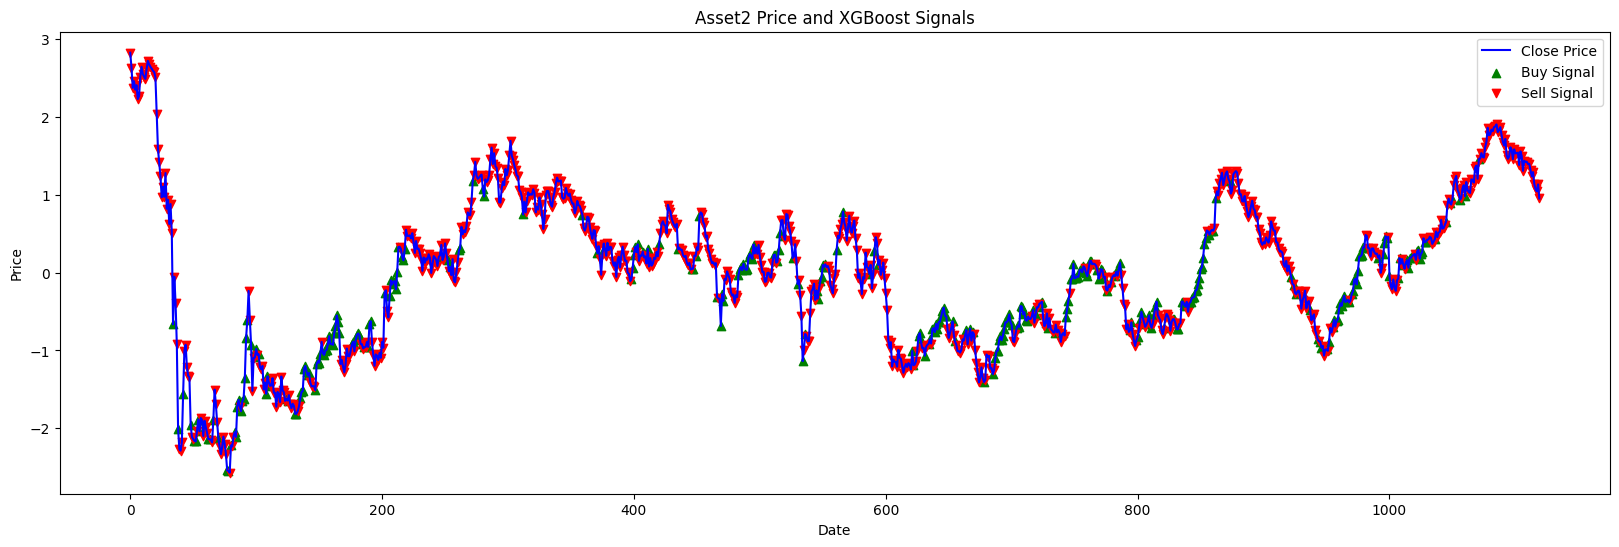

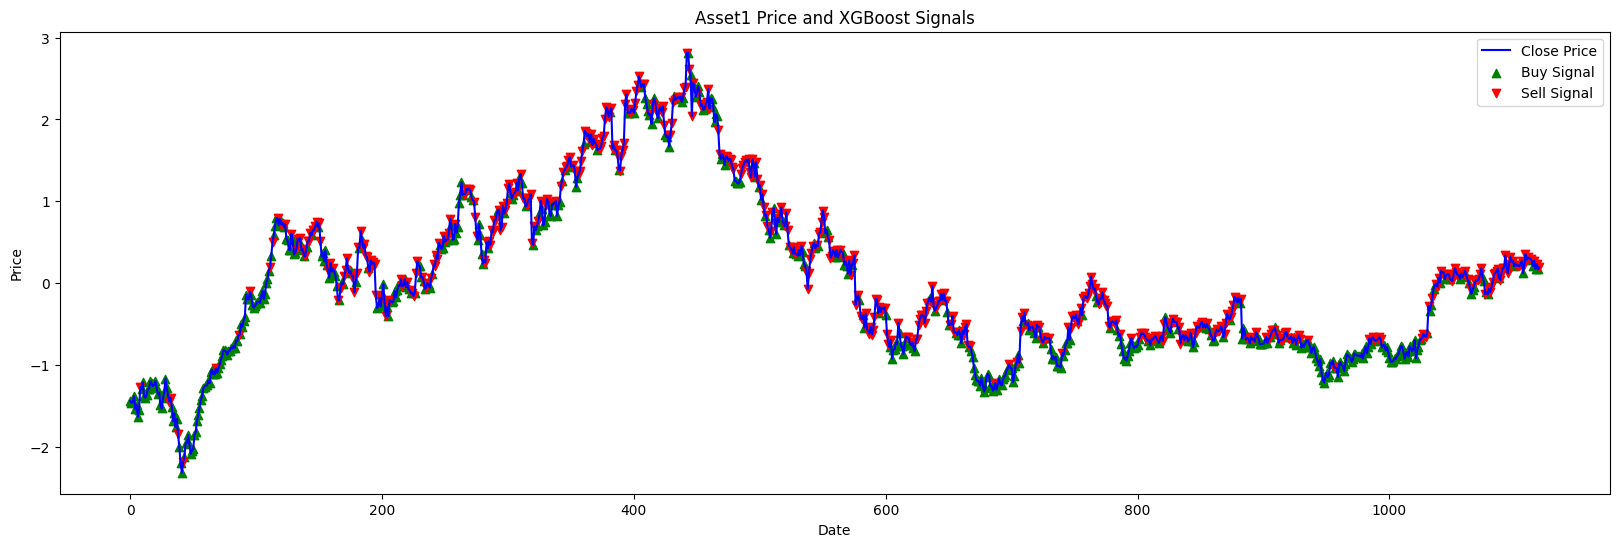

In [1335]:
# Plot signals for GRT
plot_signals_xgb(asset2_data, asset2_signals_xgb, 'Asset2 Price and XGBoost Signals')
# Plot signals for Sushi
plot_signals_xgb(asset1_data, asset1_signals_xgb, 'Asset1 Price and XGBoost Signals')

## Hidden Markov Model Strategy

These models are sourced from the "model" file in the "Hidden Markow Model" folder.

In [1336]:
hmm_model_asset1= joblib.load('C:/Users/Furkanpc/PythonWorkplace/Staj/Goaltech/My_finance_bot/Hidden_Markov_Model/hmm_model_ebay.pkl')
hmm_model_asset2 = joblib.load('C:/Users/Furkanpc/PythonWorkplace/Staj/Goaltech/My_finance_bot/Hidden_Markov_Model/hmm_model_dal.pkl')
predictions_asset1  = hmm_model_asset1.predict(asset1_data)
predictions_asset2 = hmm_model_asset2.predict(asset2_data)

In [1337]:
def label_data(data, hidden_states):
    i = 0  # Initialize index counter
    labels_0 = []  # List to store prices for state 0
    labels_1 = []  # List to store prices for state 1
    labels_2 = []  # List to store prices for state 2
    labels_3 = []  # List to store prices for state 3
    prices = data["close"].values.astype(float)  # Convert 'close' prices to a float array

    # Iterate through each hidden state
    for s in hidden_states:
        if s == 0:
            # If the state is 0, assign the current price to labels_0 and NaN to the others
            labels_0.append(prices[i])
            labels_1.append(float('nan'))
            labels_2.append(float('nan'))
            labels_3.append(float('nan'))
        if s == 1:
            # If the state is 1, assign the current price to labels_1 and NaN to the others
            labels_0.append(float('nan'))
            labels_1.append(prices[i])
            labels_2.append(float('nan'))
            labels_3.append(float('nan'))
        if s == 2:
            # If the state is 2, assign the current price to labels_2 and NaN to the others
            labels_0.append(float('nan'))
            labels_1.append(float('nan'))
            labels_2.append(prices[i])
            labels_3.append(float('nan'))
        if s == 3:
            # If the state is 3, assign the current price to labels_3 and NaN to the others
            labels_0.append(float('nan'))
            labels_1.append(float('nan'))
            labels_2.append(float('nan'))
            labels_3.append(prices[i])

        i += 1  # Increment index counter
    
    return labels_0, labels_1, labels_2, labels_3

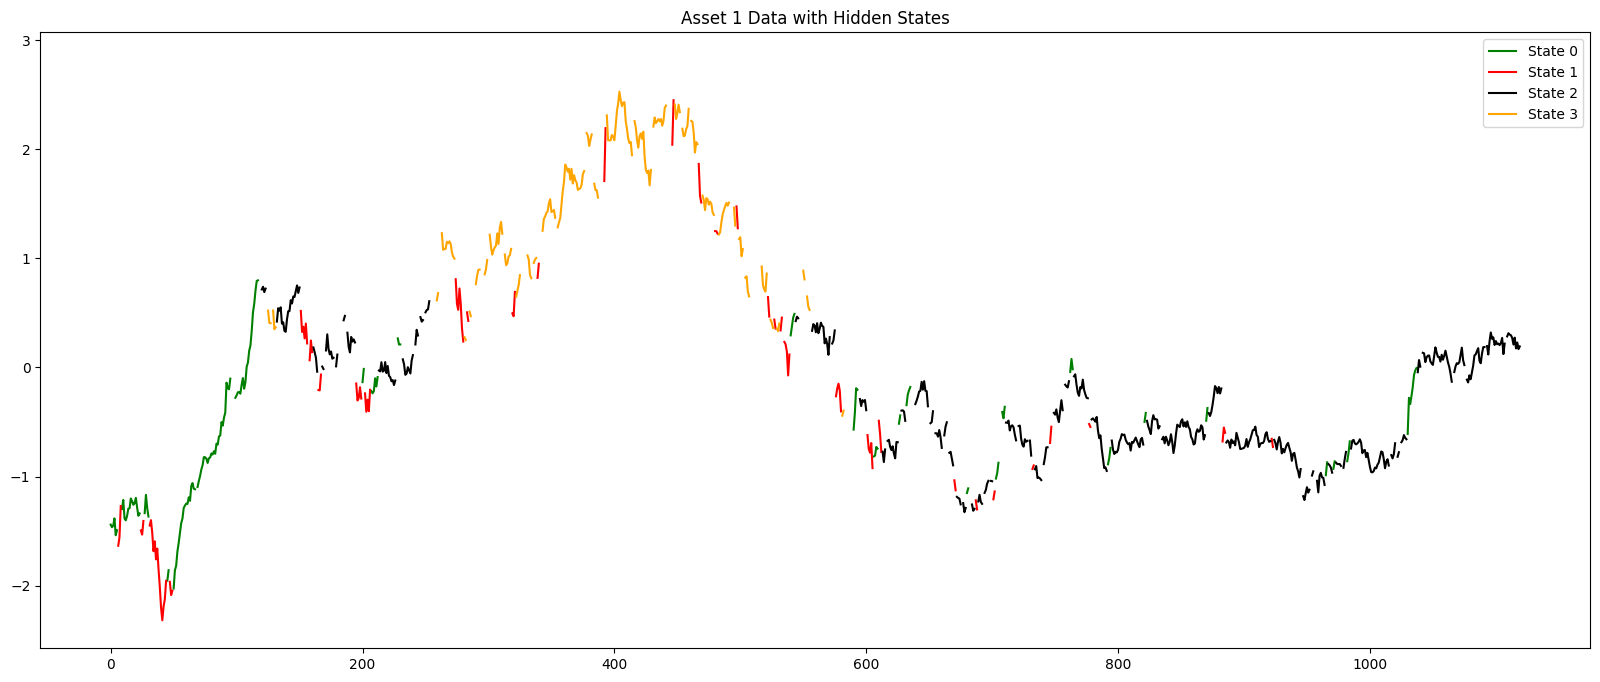

In [1338]:
# Plot the labeled data for Sushi
labels_0, labels_1, labels_2, labels_3 = label_data(asset1_data, predictions_asset1)
fig = plt.figure(figsize=(20, 8))
plt.plot(labels_0, color="green", label="State 0")
plt.plot(labels_1, color="red", label="State 1")
plt.plot(labels_2, color="black", label="State 2")
plt.plot(labels_3, color="orange", label="State 3")
plt.legend()
plt.title("Asset 1 Data with Hidden States")
plt.show()

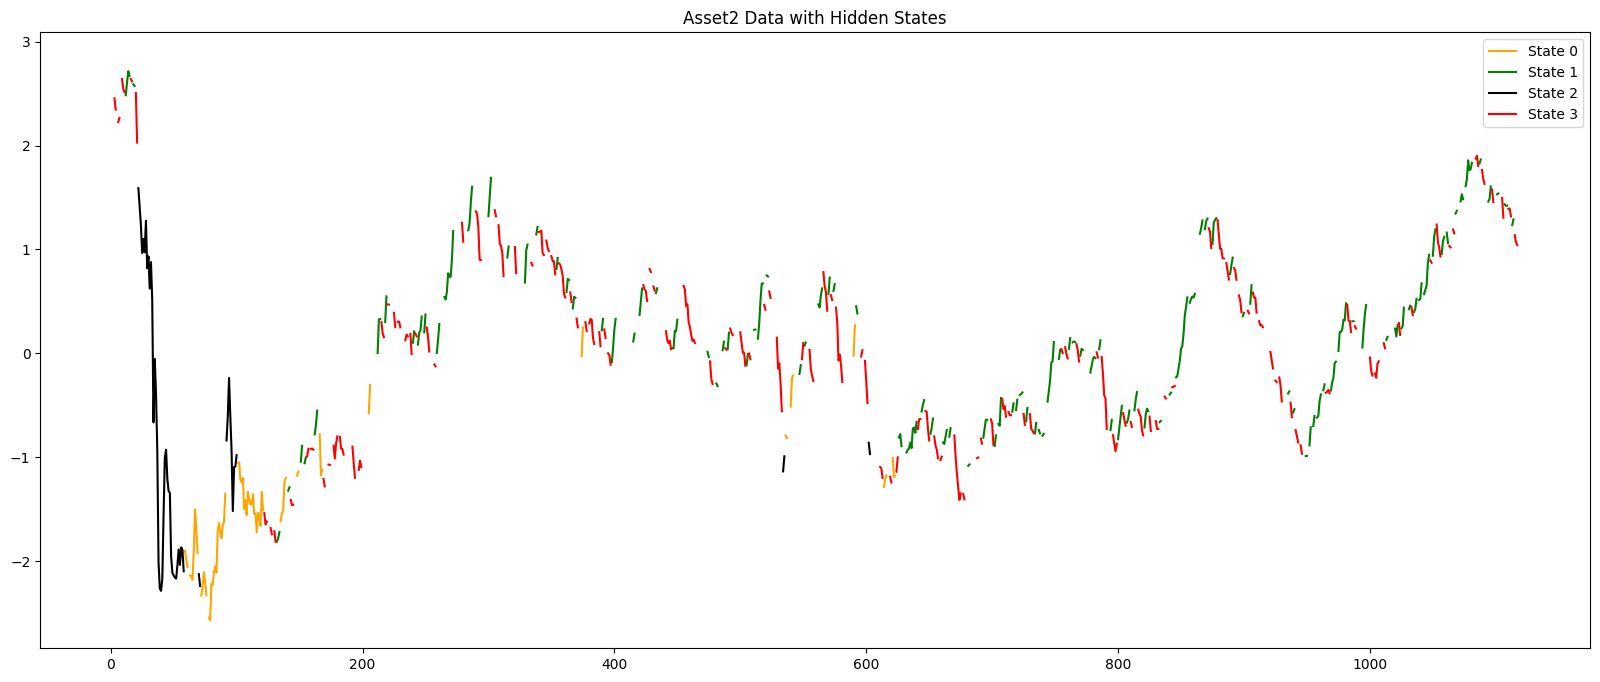

In [1339]:
# Plot the labeled data for GRT
labels_0, labels_1, labels_2, labels_3 = label_data(asset2_data, predictions_asset2)
fig = plt.figure(figsize=(20, 8))
plt.plot(labels_0, color="orange", label="State 0")
plt.plot(labels_1, color="green", label="State 1")
plt.plot(labels_2, color="black", label="State 2")
plt.plot(labels_3, color="red", label="State 3")
plt.legend()
plt.title("Asset2 Data with Hidden States")
plt.show()

The generate_HMM_signals function generates trading signals based on predictions from the HMM model and the data name.
The function iterates through the predictions and assigns trading signals (0(close), 1(buy), or -1(sell)) based on the hidden state and the dataset ("grt" or "sushı").

In [1340]:
def generate_HMM_signals(data_name, predictions):
    # Create an empty list to store buy and sell signals
    signals = []

    # Iterate over each prediction to generate trading signals
    for pred in predictions:
        # Check the prediction value and assign signals based on the data name
        if pred == 0:  
            if data_name == "asset1":
                signals.append(1)  # Append 0 for GRT when state is 0
            if data_name == "asset2":
                signals.append(1)  # Append -1 for Sushi when state is 0
        elif pred == 1:
            if data_name == "asset1":
                signals.append(-1)  # Append 1 for GRT when state is 1
            if data_name == "asset2":
                signals.append(1)  # Append 0 for Sushi when state is 1
        elif pred == 2:
            if data_name == "asset1":
                signals.append(0)  # Append 0 for GRT when state is 2
            if data_name == "asset2":
                signals.append(-1)  # Append -1 for Sushi when state is 2
        else:
            if data_name == "asset1":
                signals.append(0)  # Append -1 for GRT when state is 3
            if data_name == "asset2":
                signals.append(1)  # Append 1 for Sushi when state is 3

    return signals

In [1341]:
asset2_signals_hmm = generate_HMM_signals("asset2", predictions_asset2)
asset1_signals_hmm = generate_HMM_signals("asset1", predictions_asset1)

In [1342]:
def plot_signals(data, signals, title):
    # Convert signals to a pandas Series with the same index as the data
    signals_series = pd.Series(signals, index=data.index)
    
    # Create a figure and axis
    plt.figure(figsize=(20, 6))
    
    # Plot the close price
    plt.plot(data['close'], label='Close Price', color='blue')
    
    # Plot buy signals
    buy_signals = signals_series[signals_series == 1]
    plt.scatter(buy_signals.index, data['close'][buy_signals.index], marker='^', color='green', label='Buy Signal', alpha=1)
    
    # Plot sell signals
    sell_signals = signals_series[signals_series == -1]
    plt.scatter(sell_signals.index, data['close'][sell_signals.index], marker='v', color='red', label='Sell Signal', alpha=1)
    
    # Plot no-action signals
    no_action_signals = signals_series[signals_series == 0]
    plt.scatter(no_action_signals.index, data['close'][no_action_signals.index], marker='o', color='gray', label='No Action', alpha=0.5)
    
    # Set the title and labels
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

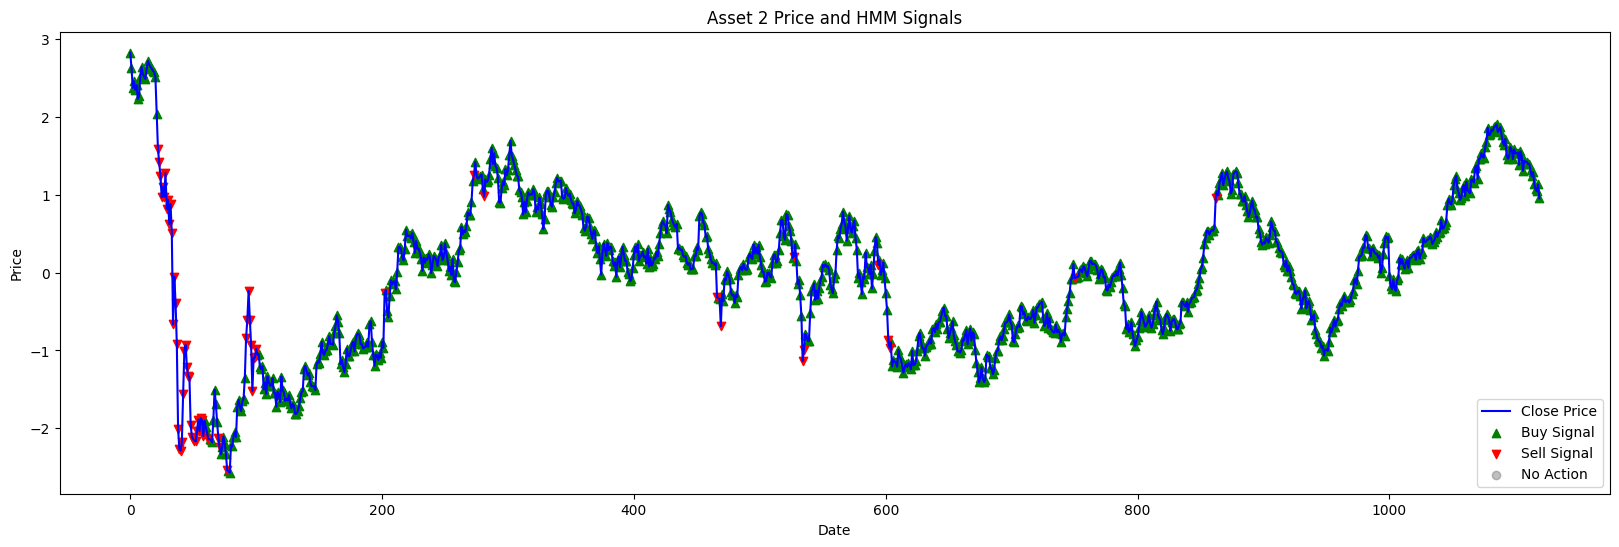

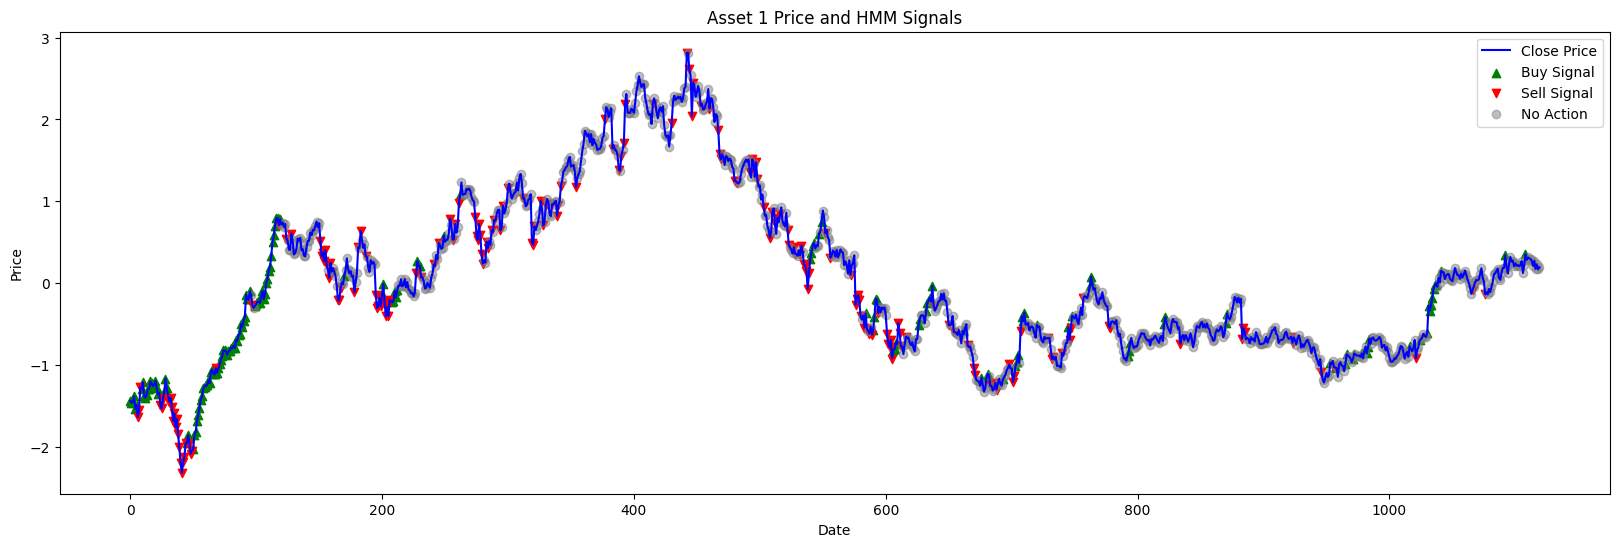

In [1343]:
# Example usage with GRT and Sushi data
plot_signals(asset2_data, asset2_signals_hmm, 'Asset 2 Price and HMM Signals')
plot_signals(asset1_data, asset1_signals_hmm, 'Asset 1 Price and HMM Signals')

## Check Signals

The function check_position_mrs calculates the current positions for two assets and extends the positions for each asset:
- It makes copies of the original positions for both assets.
- It replaces 0s in the positions with NaNs, which represent periods with no positions.
- It uses forward fill to propagate the last known position forward until a new position signal is encountered.

Extending the position ensures that the strategy maintains a continuous and consistent market exposure, which can improve its overall performance and efficiency.

In [1344]:
def check_position_mrs(date, long_signal_mrs, short_signal_mrs, asset1_close, asset2_close, prev_asset1_position, prev_asset2_position):
    # Determine the current position for asset1 and asset2 based on closing prices
    if asset1_close[date] >= asset2_close[date]:
        # Calculate positions when asset1's close price is greater than or equal to asset2's close price
        asset1_position = long_signal_mrs[date] - short_signal_mrs[date]
        asset2_position = -long_signal_mrs[date] + short_signal_mrs[date]
    else:
        # Calculate positions when asset2's close price is greater than asset1's close price
        asset2_position = long_signal_mrs[date] - short_signal_mrs[date]
        asset1_position = -long_signal_mrs[date] + short_signal_mrs[date]
    
    # If the current position is zero, use the previous position to extend the current position
    if asset1_position == 0 and prev_asset1_position is not None:
        asset1_position = prev_asset1_position
    if asset2_position == 0 and prev_asset2_position is not None:
        asset2_position = prev_asset2_position
    
    # Update the previous positions
    prev_asset1_position = asset1_position
    prev_asset2_position = asset2_position
    
    # Return the current positions and updated previous positions
    return asset1_position, asset2_position, prev_asset1_position, prev_asset2_position

In [1345]:
def check_signal_dvr(date, signals):
    # Initialize variables to store the long and short signals for today
    long_signal_today_dvr, short_signal_today_dvr = (0, 0)
    # Check if the signal for the current date is a long signal (1)
    if signals[date] == 1:
        long_signal_today_dvr = 1
        short_signal_today_dvr = 0
    # Check if the signal for the current date is a short signal (-1)
    elif signals[date] == -1:
        long_signal_today_dvr = 0
        short_signal_today_dvr = 1
    # Return the boolean values indicating the presence of long and short signals for today
    return long_signal_today_dvr, short_signal_today_dvr

In [1346]:
def check_signal_xgb(date, signals):
    # Initialize variables to store the long and short signals for today
    long_signal_today_xgb, short_signal_today_xgb = (0, 0)
    if signals[date] == 1:
        long_signal_today_xgb = 1
        short_signal_today_xgb = 0
    # Check if the signal for the current date is a short signal (-1)
    elif signals[date] == -1:
        long_signal_today_xgb = 0
        short_signal_today_xgb = 1
    # Return the boolean values indicating the presence of long and short signals for today
    return long_signal_today_xgb, short_signal_today_xgb

In [1347]:
def check_signal_hmm(date, signals):
    # Initialize variables to store the long and short signals for today
    long_signal_today_hmm, short_signal_today_hmm = (0, 0)
    if signals[date] == 1:
        long_signal_today_hmm = 1
        short_signal_today_hmm = 0
    # Check if the signal for the current date is a short signal (-1)
    elif signals[date] == -1:
        long_signal_today_hmm = 0
        short_signal_today_hmm = 1
    # Return the boolean values indicating the presence of long and short signals for today
    return long_signal_today_hmm, short_signal_today_hmm

Calculate Signal Power:

If the pos parameter is "long", the function calculates the signal power as the ratio of long signals (ones_count) to the sum of long signals and neutral signals.

If the pos parameter is not "long" (implicitly "short"), the function calculates the signal power as the ratio of short signals (negative_ones_count) to the sum of short signals and neutral signals.
Return Signal Power:

The function returns the calculated signal power based on the specified position type.

In [1348]:
def calculate_signal_power(signal_list):
    # Count the occurrences of different signals in the list
    ones_count = signal_list.count(1)
    zeros_count = signal_list.count(0)
    
    # Compute the signal power as the ratio of long signals (1) to the total number of signals
    signal_power = (ones_count) / (ones_count + zeros_count) 

    return signal_power

In [1349]:
def check_asset2_long_asset1_short(asset1_position_today, asset2_position_today, cash, position_size, date):
    # Check if today the position in asset2 is long, in asset1 is short, and there is sufficient cash for the position size
    return asset2_position_today == 1 and asset1_position_today == -1 and cash >= position_size * asset2_close.loc[date]

def check_asset1_long_asset2_short(asset1_position_today, asset2_position_today, cash, position_size, date):
    # Check if today the position in asset1 is long, in asset2 is short, and there is sufficient cash for the position size
    return asset1_position_today == 1 and asset2_position_today == -1 and cash >= position_size * asset1_close.loc[date]


## Kelly Criterion

In [1350]:
def calculate_prob_and_odds(data):
    # Define winning and losing trades based on daily returns
    winning_trades = data['daily_return'] > 0
    losing_trades = data['daily_return'] < 0
    
    # Calculate probabilities
    prob_win = winning_trades.mean()
    
    # Calculate odds
    if winning_trades.any():
        average_winning_change = data['price_change'][winning_trades].mean()
    else:
        average_winning_change = 0
    
    if losing_trades.any():
        average_losing_change = data['price_change'][losing_trades].mean()
    else:
        average_losing_change = 1  # Avoid division by zero

    # Calculate odds with adjustments to avoid division by zero
    if average_losing_change != 0:
        odds = (average_winning_change / abs(average_losing_change)) + 1
    else:
        odds = np.nan  # If there are no losing trades, odds cannot be calculated

    return prob_win, odds

# Calculate for GRT
prob_win_asset2, odds_asset2 = calculate_prob_and_odds(asset2_data)
print(f"Probability of a winning trade for Asset2: {prob_win_asset2:.2f}")
print(f"Odds received on a win for Asset2: {odds_asset2:.2f}")

# Calculate for SushiSwap
prob_win_asset1, odds_asset1 = calculate_prob_and_odds(asset1_data)
print(f"Probability of a winning trade for Asset1: {prob_win_asset1:.2f}")
print(f"Odds received on a win for Asset1: {odds_asset1:.2f}")

Probability of a winning trade for Asset2: 0.51
Odds received on a win for Asset2: 1.94
Probability of a winning trade for Asset1: 0.50
Odds received on a win for Asset1: 1.99


In [1351]:
def kelly_criterion(prob_win, odds):
    return (prob_win * (odds + 1) - 1) / odds

# Calculate optimal position sizes using Kelly Criterion
kelly_fraction_asset2 = kelly_criterion(prob_win_asset2, odds_asset2)
kelly_fraction_asset1 = kelly_criterion(prob_win_asset1, odds_asset1)

# Make sure to keep the fraction within the acceptable range (0 <= f <= 1)
kelly_fraction_asset2 = max(0, min(kelly_fraction_asset2, 1))
kelly_fraction_asset1 = max(0, min(kelly_fraction_asset1, 1))

In [1352]:
# Initial capital and portfolio variables
initial_cash = 1000
cash = initial_cash
positions_asset1 = 0
positions_asset2 = 0
portfolio_values = []
position_size = 10

# Initialize global variables to store previous positions
prev_asset1_position = None
prev_asset2_position = None

# Initialize counters for trade types
asset1_long_asset2_short_count = 0
asset2_long_asset1_short_count = 0
close_position_count = 0

# Iterate through each date to calculate portfolio values
for date in asset1_data.index:
    asset2_long_signals = []
    asset2_short_signals = []
    asset1_long_signals = []
    asset1_short_signals = []

    # Check long and short signals
    asset1_position_today, asset2_position_today, prev_asset1_position, prev_asset2_position = check_position_mrs(
        date, long_signal_mrs, short_signal_mrs, asset1_close, asset2_close, prev_asset1_position, prev_asset2_position)
    
    long_signal_today_dvr, short_signal_today_dvr = check_signal_dvr(date, asset2_signals_dvr)
    asset2_long_signals.append(long_signal_today_dvr)
    asset2_short_signals.append(short_signal_today_dvr)
    long_signal_today_dvr, short_signal_today_dvr = check_signal_dvr(date, asset1_signals_dvr)
    asset1_long_signals.append(long_signal_today_dvr)
    asset1_short_signals.append(short_signal_today_dvr)

    long_signal_today_xgb, short_signal_today_xgb = check_signal_xgb(date, asset2_signals_xgb)
    asset2_long_signals.append(long_signal_today_xgb)
    asset2_short_signals.append(short_signal_today_xgb)
    long_signal_today_xgb, short_signal_today_xgb = check_signal_xgb(date, asset1_signals_xgb)
    asset1_long_signals.append(long_signal_today_xgb)
    asset1_short_signals.append(short_signal_today_xgb)

    long_signal_today_hmm, short_signal_today_hmm = check_signal_hmm(date, asset2_signals_hmm)
    asset2_long_signals.append(long_signal_today_hmm)
    asset2_short_signals.append(short_signal_today_hmm)
    long_signal_today_hmm, short_signal_today_hmm = check_signal_hmm(date, asset1_signals_hmm)
    asset1_long_signals.append(long_signal_today_hmm)
    asset1_short_signals.append(short_signal_today_hmm)

    # Calculate the power of each signal type
    asset2_long_signal_power = calculate_signal_power(asset2_long_signals)
    asset2_short_signal_power = calculate_signal_power(asset2_short_signals)
    asset1_long_signal_power = calculate_signal_power(asset1_long_signals)
    asset1_short_signal_power = calculate_signal_power(asset1_short_signals)

    # Managing positions
    if check_asset2_long_asset1_short(asset1_position_today, asset2_position_today, cash, position_size, date):
        # Opening a long position in GRT and a short position in SushiSwap
        new_positions_asset2 = position_size * asset2_long_signal_power * kelly_fraction_asset2
        new_positions_asset1 = new_positions_asset2 * hedge_ratio * asset1_short_signal_power * kelly_fraction_asset1
        # Update positions and cash for long GRT and short SushiSwap
        positions_asset2 += new_positions_asset2
        positions_asset1 -= new_positions_asset1
        cash -= new_positions_asset2 * asset2_close.loc[date]  # Spending cash to buy GRT
        cash += new_positions_asset1 * asset1_close.loc[date]  # Gaining cash from shorting SushiSwap
        asset2_long_asset1_short_count += 1

    elif check_asset1_long_asset2_short(asset1_position_today, asset2_position_today, cash, position_size, date):
        # Opening a long position in SushiSwap and a short position in GRT
        new_positions_asset1 = position_size * asset1_long_signal_power * kelly_fraction_asset1
        new_positions_asset2 = new_positions_asset1 / hedge_ratio * asset2_short_signal_power * kelly_fraction_asset2
        # Update positions and cash for long SushiSwap and short GRT
        positions_asset1 += new_positions_asset1
        positions_asset2 -= new_positions_asset2
        cash -= new_positions_asset1 * asset1_close.loc[date]  # Spending cash to buy SushiSwap
        cash += new_positions_asset2 * asset2_close.loc[date]  # Gaining cash from shorting GRT
        asset1_long_asset2_short_count += 1

    # Closing positions (If no signal, close current positions)
    else:
        cash += positions_asset2 * asset2_close.loc[date]  # Gaining cash from closing GRT positions
        cash += positions_asset1 * asset1_close.loc[date]  # Gaining cash from closing SushiSwap positions
        positions_asset2 = 0
        positions_asset1 = 0
        close_position_count += 1

    # Calculate the portfolio value
    portfolio_value = cash + (positions_asset2 * asset2_close.loc[date]) + (positions_asset1 * asset1_close.loc[date])
    portfolio_values.append(portfolio_value)

Initial Capital: $1000.00
Final Portfolio Value: $1996.44
Total Return: 99.64%
Maximum Portfolio Value: $2732.36
Minimum Portfolio Value: $303.99
Most Profitable Trade: $260.53 from 861 to 862
Least Profitable Trade: $-368.64 from 999 to 1000
Asset1 Long Asset2 Short Trades Count: 409
Asset2 Long Asset1 Short Trades Count: 682
Close Position Trades Count: 29
Sharpe Ratio: -0.51


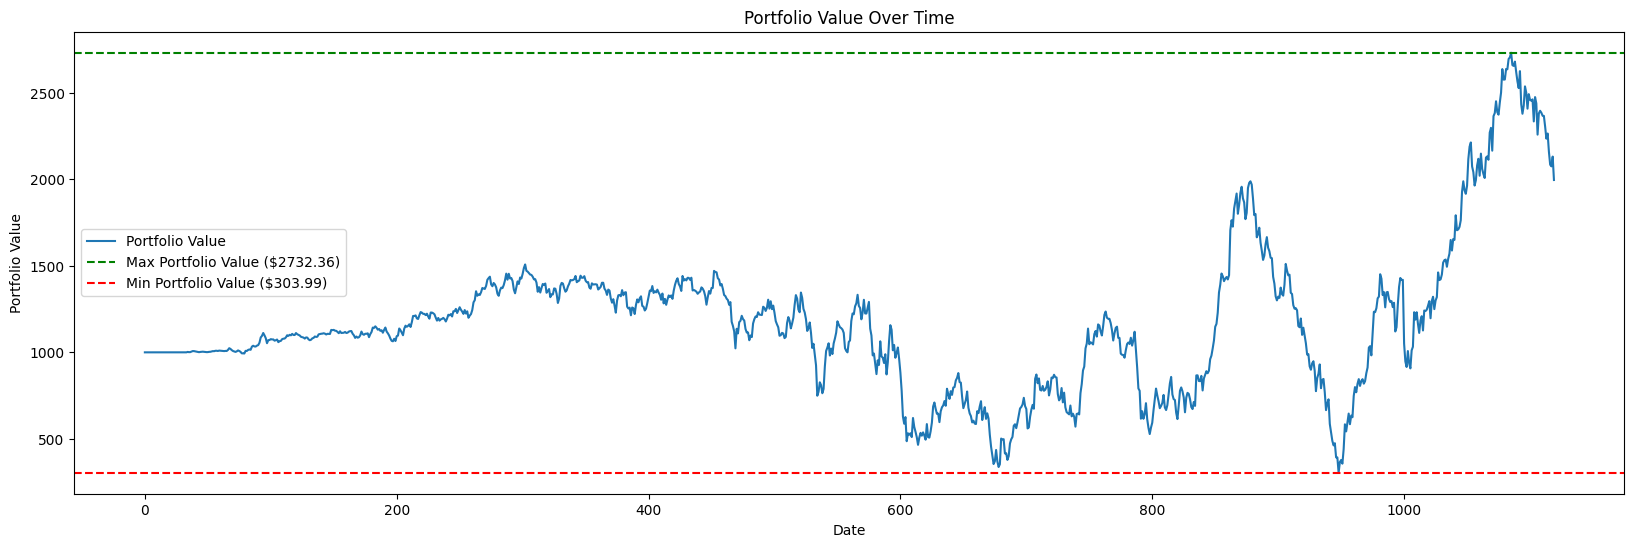

In [1353]:
# Initialize variables to track trades
trades = []
max_portfolio_value = initial_cash
min_portfolio_value = initial_cash
max_trade_profit = -float('inf')
min_trade_loss = float('inf')
trade_start_value = initial_cash
trade_start_date = None

# Create a Series for the portfolio values with dates as the index
portfolio_series = pd.Series(portfolio_values, index=asset1_data.index)

# Calculate performance metrics
final_portfolio_value = portfolio_series.iloc[-1]  # Use .iloc to get the last value
return_rate = (final_portfolio_value - initial_cash) / initial_cash
cumulative_return = portfolio_series.pct_change().cumsum()  # Cumulative return

# Calculate daily returns
daily_returns = portfolio_series.pct_change().dropna()

# Risk-free rate (can be adjusted based on actual risk-free rate)
risk_free_rate = 0.03

# Calculate Sharpe Ratio
mean_return = daily_returns.mean()
std_dev = daily_returns.std()
sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan

# Iterate through the portfolio values to track trades and performance
for i in range(1, len(portfolio_series)):
    current_date = portfolio_series.index[i]
    current_value = portfolio_series.iloc[i]
    
    # Track maximum and minimum portfolio values
    if current_value > max_portfolio_value:
        max_portfolio_value = current_value
    if current_value < min_portfolio_value:
        min_portfolio_value = current_value
    
    # Check for trade entries and exits
    if current_value != trade_start_value:
        if trade_start_value != initial_cash:
            trade_profit = current_value - trade_start_value
            trades.append((trade_start_date, current_date, trade_profit))
            if trade_profit > max_trade_profit:
                max_trade_profit = trade_profit
                max_trade_start_date = trade_start_date
                max_trade_end_date = current_date
            if trade_profit < min_trade_loss:
                min_trade_loss = trade_profit
                min_trade_start_date = trade_start_date
                min_trade_end_date = current_date
        
        trade_start_value = current_value
        trade_start_date = current_date

# Print results
print(f"Initial Capital: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Total Return: {return_rate:.2%}")
print(f"Maximum Portfolio Value: ${max_portfolio_value:.2f}")
print(f"Minimum Portfolio Value: ${min_portfolio_value:.2f}")

# Print most profitable and least profitable trades
print(f"Most Profitable Trade: ${max_trade_profit:.2f} from {max_trade_start_date} to {max_trade_end_date}")
print(f"Least Profitable Trade: ${min_trade_loss:.2f} from {min_trade_start_date} to {min_trade_end_date}")

# Print trade counts
print(f"Asset1 Long Asset2 Short Trades Count: {asset1_long_asset2_short_count}")
print(f"Asset2 Long Asset1 Short Trades Count: {asset2_long_asset1_short_count}")
print(f"Close Position Trades Count: {close_position_count}")

# Print Sharpe Ratio
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Visualize the portfolio value over time
plt.figure(figsize=(20, 6))
plt.plot(portfolio_series, label='Portfolio Value')
plt.axhline(y=max_portfolio_value, color='g', linestyle='--', label=f'Max Portfolio Value (${max_portfolio_value:.2f})')
plt.axhline(y=min_portfolio_value, color='r', linestyle='--', label=f'Min Portfolio Value (${min_portfolio_value:.2f})')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()